<a href="https://colab.research.google.com/github/felizzi/Glaucoma_Studies/blob/main/Glaucoma_Model_Final_01ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Definition of the General Parameter Class

In [3]:
@dataclass
class Parameter:
    """Simple parameter class with sampling capability"""
    mean: float
    std: float
    dist_type: str = 'normal'  # normal, gamma, beta

    def sample(self, n=1):
        """Sample from parameter distribution"""
        if self.std == 0:
            return np.full(n, self.mean)
        if self.dist_type == 'gamma':
            shape = (self.mean / self.std) ** 2
            scale = self.std ** 2 / self.mean
            return np.random.gamma(shape, scale, n)
        elif self.dist_type == 'beta':
            alpha = self.mean * (self.mean * (1 - self.mean) / self.std**2 - 1)
            beta = (1 - self.mean) * (self.mean * (1 - self.mean) / self.std**2 - 1)
            return np.random.beta(max(alpha, 0.1), max(beta, 0.1), n)
        else:  # normal
            return np.maximum(0, np.random.normal(self.mean, self.std, n))

print("Parameter class defined!")

Parameter class defined!


## Definition of the Glaucoma Parameter Class

In [59]:
class GlaucomaParameters:
    """All model parameters in one place"""

    def __init__(self, scenario_name="Default",
                 mild_to_moderate_mean=0.15, mild_to_moderate_std=0.05,
                 moderate_to_severe_mean=0.12, moderate_to_severe_std=0.04,
                 severe_to_vi_mean=0.10, severe_to_vi_std=0.03,
                 true_positive_rate=0.90, tp_std=0.05,
                 true_negative_rate=0.85, tn_std=0.05,
                 false_positive_rate=0.15, fp_std=0.05,
                 false_negative_rate=0.10, fn_std=0.05,
                 sensitivity=0.775, sensitivity_std=0.066,
                 specificity=0.954, specificity_std=0.009,
                 # State-specific screening accuracy parameters
                 tp_mild=0.85, tp_mild_std=0.05,
                 tn_mild=0.90, tn_mild_std=0.05,
                 fp_mild=0.10, fp_mild_std=0.05,
                 fn_mild=0.15, fn_mild_std=0.05,
                 tp_moderate=0.90, tp_moderate_std=0.05,
                 tn_moderate=0.88, tn_moderate_std=0.05,
                 fp_moderate=0.12, fp_moderate_std=0.05,
                 fn_moderate=0.10, fn_moderate_std=0.05,
                 tp_severe=0.95, tp_severe_std=0.04,
                 tn_severe=0.85, tn_severe_std=0.05,
                 fp_severe=0.15, fp_severe_std=0.05,
                 fn_severe=0.05, fn_severe_std=0.04,
                 detection_proportion=1.0, detection_std=0.000001,
                 prevalence_general=0.05, prevalence_general_std=0.005,
                 prevalence_dr=0.07, prevalence_dr_std=0.01,
                 screening_cost=10, screening_cost_std=0.01,
                 # Separate screening costs
                 ai_screening_cost=30, ai_screening_cost_std=5,
                 human_screening_cost=75, human_screening_cost_std=15):

        self.scenario_name = scenario_name

        # COSTS (annual, in USD)
        self.costs = {
            'monitoring_mild': Parameter(352, 0.2*352, 'gamma'),
            'monitoring_moderate': Parameter(463, 0.2*463, 'gamma'),
            'monitoring_severe': Parameter(644, 0.2*644, 'gamma'),
            'monitoring_vi': Parameter(576, 0.2*576, 'gamma'),
            'treatment_mild': Parameter(303, 0.2*303, 'gamma'),
            'treatment_moderate': Parameter(429, 0.2*429, 'gamma'),
            'treatment_severe': Parameter(609, 0.2*609, 'gamma'),
            'treatment_vi': Parameter(662, 0.2*662, 'gamma'),
            'other_mild': Parameter(0, 0, 'gamma'),
            'other_moderate': Parameter(0, 0, 'gamma'),
            'other_severe': Parameter(0, 0, 'gamma'),
            'other_vi': Parameter(4186 + 1334, 0.2*(4186 + 1334), 'gamma'),
            'productivity_mild': Parameter(0, 0, 'gamma'),
            'productivity_moderate': Parameter(0, 0, 'gamma'),
            'productivity_severe': Parameter(0, 0, 'gamma'),
            'productivity_vi': Parameter(7630, 0.2*7630, 'gamma'),
            'screening': Parameter(screening_cost, screening_cost_std, 'gamma'),
            'ai_screening': Parameter(ai_screening_cost, ai_screening_cost_std, 'gamma'),
            'human_screening': Parameter(human_screening_cost, human_screening_cost_std, 'gamma'),
        }

        # UTILITIES (0-1 scale)
        self.utilities = {
            'utility_mild': Parameter(0.985, 0.023, 'beta'),
            'utility_moderate': Parameter(0.899, 0.039, 'beta'),
            'utility_severe': Parameter(0.773, 0.046, 'beta'),
            'utility_vi': Parameter(0.634, 0.052, 'beta'),
        }

        # TRANSITION PROBABILITIES
        self.transitions = {
            'mild_to_moderate': Parameter(mild_to_moderate_mean, mild_to_moderate_std, 'beta'),
            'moderate_to_severe': Parameter(moderate_to_severe_mean, moderate_to_severe_std, 'beta'),
            'severe_to_vi': Parameter(severe_to_vi_mean, severe_to_vi_std, 'beta'),
        }

        # SCREENING ACCURACY PARAMETERS (overall)
        self.screening_accuracy = {
            'true_positive_rate': Parameter(true_positive_rate, tp_std, 'beta'),
            'true_negative_rate': Parameter(true_negative_rate, tn_std, 'beta'),
            'false_positive_rate': Parameter(false_positive_rate, fp_std, 'beta'),
            'false_negative_rate': Parameter(false_negative_rate, fn_std, 'beta'),
            'sensitivity': Parameter(sensitivity, sensitivity_std, 'beta'),
            'specificity': Parameter(specificity, specificity_std, 'beta'),
        }

        # STATE-SPECIFIC SCREENING ACCURACY PARAMETERS
        self.screening_accuracy_mild = {
            'tp_mild': Parameter(tp_mild, tp_mild_std, 'beta'),
            'tn_mild': Parameter(tn_mild, tn_mild_std, 'beta'),
            'fp_mild': Parameter(fp_mild, fp_mild_std, 'beta'),
            'fn_mild': Parameter(fn_mild, fn_mild_std, 'beta'),
        }

        self.screening_accuracy_moderate = {
            'tp_moderate': Parameter(tp_moderate, tp_moderate_std, 'beta'),
            'tn_moderate': Parameter(tn_moderate, tn_moderate_std, 'beta'),
            'fp_moderate': Parameter(fp_moderate, fp_moderate_std, 'beta'),
            'fn_moderate': Parameter(fn_moderate, fn_moderate_std, 'beta'),
        }

        self.screening_accuracy_severe = {
            'tp_severe': Parameter(tp_severe, tp_severe_std, 'beta'),
            'tn_severe': Parameter(tn_severe, tn_severe_std, 'beta'),
            'fp_severe': Parameter(fp_severe, fp_severe_std, 'beta'),
            'fn_severe': Parameter(fn_severe, fn_severe_std, 'beta'),
        }

        # DETECTION AND PREVALENCE PARAMETERS
        self.screening_params = {
            'detection_proportion': Parameter(detection_proportion, detection_std, 'beta'),
            'prevalence_general': Parameter(prevalence_general, prevalence_general_std, 'beta'),
            'prevalence_dr': Parameter(prevalence_dr, prevalence_dr_std, 'beta'),
        }

        # DISCOUNT RATES
        self.discount_rates = {
            'cost_discount': Parameter(0.03, 0.01, 'beta'),
            'health_discount': Parameter(0.015, 0.005, 'beta'),
        }

    @classmethod
    def create_ai_pure_scenario(cls, **kwargs):
        """AI PURE SCENARIO - AI transition matrix + AI screening"""
        defaults = {
            'scenario_name': "AI Pure",
            'mild_to_moderate_mean': 0.058, 'mild_to_moderate_std': 0.000303,
            'moderate_to_severe_mean': 0.04, 'moderate_to_severe_std': 0.000253,
            'severe_to_vi_mean': 0.032, 'severe_to_vi_std': 0.00023,
            'true_positive_rate': 0.95, 'tp_std': 0.02,
            'true_negative_rate': 0.92, 'tn_std': 0.02,
            'false_positive_rate': 0.08, 'fp_std': 0.02,
            'false_negative_rate': 0.05, 'fn_std': 0.02,
            'sensitivity' : 0.775, 'sensitivity_std': 0.066,
            'specificity' : 0.954, 'specificity_std': 0.009,
            # AI-enhanced state-specific screening accuracy
            'tp_mild': 0.92, 'tp_mild_std': 0.03,
            'tn_mild': 0.94, 'tn_mild_std': 0.02,
            'fp_mild': 0.06, 'fp_mild_std': 0.02,
            'fn_mild': 0.08, 'fn_mild_std': 0.03,
            'tp_moderate': 0.95, 'tp_moderate_std': 0.02,
            'tn_moderate': 0.93, 'tn_moderate_std': 0.02,
            'fp_moderate': 0.07, 'fp_moderate_std': 0.02,
            'fn_moderate': 0.05, 'fn_moderate_std': 0.02,
            'tp_severe': 0.98, 'tp_severe_std': 0.01,
            'tn_severe': 0.91, 'tn_severe_std': 0.02,
            'fp_severe': 0.09, 'fp_severe_std': 0.02,
            'fn_severe': 0.02, 'fn_severe_std': 0.01,
            'detection_proportion': 0.90, 'detection_std': 0.05,
            # AI screening costs
            'ai_screening_cost': 11.5, 'ai_screening_cost_std': 3, ## AI screening costs include
            'human_screening_cost': 100, 'human_screening_cost_std': 12,
        }
        defaults.update(kwargs)
        return cls(**defaults)

    @classmethod
    def create_non_ai_pure_scenario(cls, **kwargs):
        """NON-AI PURE SCENARIO - Non-AI transition matrix + Non-AI screening"""
        defaults = {
            'scenario_name': "Non-AI Pure",
            'mild_to_moderate_mean': 0.143, 'mild_to_moderate_std': 0.0323,
            'moderate_to_severe_mean': 0.087, 'moderate_to_severe_std': 0.02603,
            'severe_to_vi_mean': 0.077, 'severe_to_vi_std': 0.02467,
            'true_positive_rate': 0.75, 'tp_std': 0.08,
            'true_negative_rate': 0.80, 'tn_std': 0.08,
            'false_positive_rate': 0.20, 'fp_std': 0.08,
            'false_negative_rate': 0.25, 'fn_std': 0.08,
            # Non-AI state-specific screening accuracy (lower performance)
            'tp_mild': 0.70, 'tp_mild_std': 0.08,
            'tn_mild': 0.85, 'tn_mild_std': 0.06,
            'fp_mild': 0.15, 'fp_mild_std': 0.06,
            'fn_mild': 0.30, 'fn_mild_std': 0.08,
            'tp_moderate': 0.78, 'tp_moderate_std': 0.07,
            'tn_moderate': 0.82, 'tn_moderate_std': 0.06,
            'fp_moderate': 0.18, 'fp_moderate_std': 0.06,
            'fn_moderate': 0.22, 'fn_moderate_std': 0.07,
            'tp_severe': 0.88, 'tp_severe_std': 0.05,
            'tn_severe': 0.78, 'tn_severe_std': 0.07,
            'fp_severe': 0.22, 'fp_severe_std': 0.07,
            'fn_severe': 0.12, 'fn_severe_std': 0.05,
            'detection_proportion': 0.70, 'detection_std': 0.10,
            # Human screening costs (higher due to specialist time)
            'ai_screening_cost': 0.01, 'ai_screening_cost_std': 0.0001,
            'human_screening_cost': 0.01, 'human_screening_cost_std': 0.0000001,
        }
        defaults.update(kwargs)
        instance = cls(**defaults)

        instance._set_non_ai_cost_structure()
        return instance

    def _set_non_ai_cost_structure(self):
        """Set Non-AI cost structure: ONLY VI patients incur costs"""
        zero_cost = Parameter(0, 0, 'gamma')

        # Zero out all costs except VI
        self.costs.update({
            # NO costs for undetected cases
            'monitoring_mild': zero_cost,
            'monitoring_moderate': zero_cost,
            'monitoring_severe': zero_cost,
            'treatment_mild': zero_cost,
            'treatment_moderate': zero_cost,
            'treatment_severe': zero_cost,
            'other_mild': zero_cost,
            'other_moderate': zero_cost,
            'other_severe': zero_cost,
            'productivity_mild': zero_cost,
            'productivity_moderate': zero_cost,
            'productivity_severe': zero_cost,

            # VI costs remain the same (clinically obvious)
            # 'monitoring_vi': unchanged
            # 'treatment_vi': unchanged
            # 'other_vi': unchanged
            # 'productivity_vi': unchanged
        })

        print(f"Applied Non-AI cost structure: Only VI patients incur costs")

    def sample_all(self):
        """Sample all parameters once"""
        sample = {}
        for category in [self.costs, self.utilities, self.transitions,
                        self.screening_accuracy, self.screening_accuracy_mild,
                        self.screening_accuracy_moderate, self.screening_accuracy_severe,
                        self.screening_params, self.discount_rates]:
            for name, param in category.items():
                sample[name] = param.sample(1)[0]
        return sample

    def get_summary(self):
        """Get parameter summary as DataFrame"""
        data = []
        for category_name, category in [('Costs', self.costs),
                                       ('Utilities', self.utilities),
                                       ('Transitions', self.transitions),
                                       ('Screening_Accuracy', self.screening_accuracy),
                                       ('Screening_Accuracy_Mild', self.screening_accuracy_mild),
                                       ('Screening_Accuracy_Moderate', self.screening_accuracy_moderate),
                                       ('Screening_Accuracy_Severe', self.screening_accuracy_severe),
                                       ('Screening_Params', self.screening_params),
                                       ('Discount_Rates', self.discount_rates)]:
            for name, param in category.items():
                data.append({
                    'Category': category_name,
                    'Parameter': name,
                    'Mean': param.mean,
                    'Std': param.std,
                    'Distribution': param.dist_type
                })
        return pd.DataFrame(data)

    def get_screening_cost(self, screening_type='combined'):
        """Get screening cost based on type"""
        if screening_type == 'ai_only':
            return self.costs['ai_screening']
        elif screening_type == 'human_only':
            return self.costs['human_screening']
        elif screening_type == 'combined':
            return self.costs['screening']
        else:
            raise ValueError(f"Unknown screening type: {screening_type}. Use 'ai_only', 'human_only', or 'combined'")

    def get_state_specific_accuracy(self, state):
        """Get screening accuracy parameters for a specific state"""
        if state == 'mild':
            return self.screening_accuracy_mild
        elif state == 'moderate':
            return self.screening_accuracy_moderate
        elif state == 'severe':
            return self.screening_accuracy_severe
        else:
            raise ValueError(f"Unknown state: {state}. Use 'mild', 'moderate', or 'severe'")

print("Enhanced GlaucomaParameters class defined with state-specific screening accuracy!")

Enhanced GlaucomaParameters class defined with state-specific screening accuracy!


# Quick instantiation of the classes above


In [60]:
# Quick instantiation examples for GlaucomaParameters class

# 1. Default scenario
params_default = GlaucomaParameters()

# 2. AI Pure scenario
params_ai = GlaucomaParameters.create_ai_pure_scenario()

# 3. Non-AI Pure scenario
params_non_ai = GlaucomaParameters.create_non_ai_pure_scenario()

# 4. Custom scenario with specific parameters
#params_custom = GlaucomaParameters(
#    scenario_name="Custom Hybrid",
#    mild_to_moderate_mean=0.10,
#    true_positive_rate=0.88,
#    ai_screening_cost=20,
#    human_screening_cost=90
#)

# Quick verification - print scenario names
print(f"Default: {params_default.scenario_name}")
print(f"AI Pure: {params_ai.scenario_name}")
print(f"Non-AI Pure: {params_non_ai.scenario_name}")
#rint(f"Custom: {params_custom.scenario_name}")

# Sample all parameters for one scenario
sample_data = params_ai.sample_all()
print(f"\nSample AI screening cost: ${sample_data['ai_screening']:.2f}")
print(f"Sample human screening cost: ${sample_data['human_screening']:.2f}")

# Get parameter summary
summary_df = params_ai.get_summary()
print(f"\nAI Pure scenario has {len(summary_df)} parameters total")

Applied Non-AI cost structure: Only VI patients incur costs
Default: Default
AI Pure: AI Pure
Non-AI Pure: Non-AI Pure

Sample AI screening cost: $6.48
Sample human screening cost: $82.76

AI Pure scenario has 49 parameters total


# Model Definition
## Base Glaucoma Model
##

In [9]:
class BaseGlaucomaModel:
    """Base class for Glaucoma Health Economic Models"""

    def __init__(self, params=None):
        self.params = params or GlaucomaParameters()
        self.states = ['Mild', 'Moderate', 'Severe', 'VI']
        self.scenario_name = self.params.scenario_name

    def get_transition_matrix(self, sample):
        """Build transition matrix from sampled parameters"""
        p1 = sample['mild_to_moderate']
        p2 = sample['moderate_to_severe']
        p3 = sample['severe_to_vi']
        p1, p2, p3 = np.clip([p1, p2, p3], 0, 1)
        return np.array([
            [1-p1, p1, 0, 0],
            [0, 1-p2, p2, 0],
            [0, 0, 1-p3, p3],
            [0, 0, 0, 1]
        ])

    def simulate_cohort(self, initial_dist, years, sample):
        """Simulate cohort over time"""
        n_states = len(self.states)
        cohort = np.zeros((years + 1, n_states))
        cohort[0] = initial_dist
        trans_matrix = self.get_transition_matrix(sample)
        for year in range(years):
            cohort[year + 1] = cohort[year] @ trans_matrix
        return cohort

    def create_detailed_traces(self, cohort, costs, qalys, costs_disc, qalys_disc,
                              state_costs, state_utilities, sample, screening_costs):
        """Create detailed year-by-year traces"""
        years = len(cohort)
        trace_data = []

        for year in range(years):
            cost_discount_factor = 1 / (1 + sample['cost_discount']) ** year
            health_discount_factor = 1 / (1 + sample['health_discount']) ** year
            state_costs_year = cohort[year] * state_costs
            state_utilities_year = cohort[year] * state_utilities

            row = {
                'Year': year,
                'Prop_Mild': cohort[year][0],
                'Prop_Moderate': cohort[year][1],
                'Prop_Severe': cohort[year][2],
                'Prop_VI': cohort[year][3],
                'Total_Cost': costs[year],
                'Total_QALY': qalys[year],
                'Total_Cost_Disc': costs_disc[year],
                'Total_QALY_Disc': qalys_disc[year],
                'Screening_Cost': screening_costs[year],
                'Cost_Mild': state_costs_year[0],
                'Cost_Moderate': state_costs_year[1],
                'Cost_Severe': state_costs_year[2],
                'Cost_VI': state_costs_year[3],
                'QALY_Mild': state_utilities_year[0],
                'QALY_Moderate': state_utilities_year[1],
                'QALY_Severe': state_utilities_year[2],
                'QALY_VI': state_utilities_year[3],
                'Cost_Discount_Factor': cost_discount_factor,
                'Health_Discount_Factor': health_discount_factor,
            }
            trace_data.append(row)

        return pd.DataFrame(trace_data)

    # Abstract methods to be implemented by subclasses
    def calculate_outcomes(self, cohort, sample, include_screening=True, population_type='general'):
        raise NotImplementedError("Subclasses must implement calculate_outcomes")

    def run_deterministic(self, initial_dist=None, years=10, include_screening=True, population_type='general'):
        raise NotImplementedError("Subclasses must implement run_deterministic")

    def run_probabilistic(self, n_iterations=1000, initial_dist=None, years=10,
                         include_screening=False, population_type='general', random_seed=42, return_traces=False):
        raise NotImplementedError("Subclasses must implement run_probabilistic")


class AIGlaucomaModel(BaseGlaucomaModel):
    """AI-Enhanced Glaucoma Model with advanced screening and early detection"""

    def __init__(self, params=None):
        if params is None:
            params = GlaucomaParameters.create_ai_pure_scenario()
        super().__init__(params)
        self.model_type = "AI_Enhanced"

    def calculate_outcomes(self, cohort, sample, include_screening=True, population_type='general'):
        """AI model: All detected cases incur monitoring and treatment costs"""
        years = len(cohort)
        costs = np.zeros(years)
        qalys = np.zeros(years)
        costs_discounted = np.zeros(years)
        qalys_discounted = np.zeros(years)
        screening_costs = np.zeros(years)

        cost_discount_rate = sample['cost_discount']
        health_discount_rate = sample['health_discount']

        # AI Model: ALL states incur costs when detected (comprehensive care)
        state_costs = [
            sample['monitoring_mild'] + sample['treatment_mild'] + sample['other_mild'] + sample['productivity_mild'],
            sample['monitoring_moderate'] + sample['treatment_moderate'] + sample['other_moderate'] + sample['productivity_moderate'],
            sample['monitoring_severe'] + sample['treatment_severe'] + sample['other_severe'] + sample['productivity_severe'],
            sample['monitoring_vi'] + sample['treatment_vi'] + sample['other_vi'] + sample['productivity_vi']
        ]

        state_utilities = [
            sample['utility_mild'],
            sample['utility_moderate'],
            sample['utility_severe'],
            sample['utility_vi']
        ]

        if include_screening:
            # AI screening cost
            annual_screening_cost = sample['ai_screening']
            # AI advantage: Higher detection rate means more people get appropriate care
            detection_multiplier = sample['detection_proportion']
        else:
            annual_screening_cost = 0
            detection_multiplier = 1.0

        for year in range(years):
            # AI model: Costs scale with detection capability
            costs[year] = np.sum(cohort[year] * state_costs) * detection_multiplier
            qalys[year] = np.sum(cohort[year] * state_utilities)

            if include_screening and year == 0:
                screening_costs[year] = annual_screening_cost
                costs[year] += screening_costs[year]

            cost_discount_factor = 1 / (1 + cost_discount_rate) ** year
            health_discount_factor = 1 / (1 + health_discount_rate) ** year
            costs_discounted[year] = costs[year] * cost_discount_factor
            qalys_discounted[year] = qalys[year] * health_discount_factor

        return costs, qalys, costs_discounted, qalys_discounted, state_costs, state_utilities, screening_costs

    def run_deterministic(self, initial_dist=None, years=10, include_screening=True, population_type='general'):
        """Run AI model with mean parameter values"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]

        sample = self.params.sample_all()
        # Use mean values for deterministic
        for key in sample:
            if hasattr(self.params, 'costs') and key in [p for cat in [self.params.costs, self.params.utilities,
                      self.params.transitions, self.params.screening_accuracy, self.params.screening_accuracy_mild,
                      self.params.screening_accuracy_moderate, self.params.screening_accuracy_severe,
                      self.params.screening_params, self.params.discount_rates] for p in cat]:
                sample[key] = getattr(self.params.costs.get(key) or
                                    self.params.utilities.get(key) or
                                    self.params.transitions.get(key) or
                                    self.params.screening_accuracy.get(key) or
                                    self.params.screening_accuracy_mild.get(key) or
                                    self.params.screening_accuracy_moderate.get(key) or
                                    self.params.screening_accuracy_severe.get(key) or
                                    self.params.screening_params.get(key) or
                                    self.params.discount_rates.get(key), 'mean', 0)

        # Simplified - just use sample_all() which gives us sampled values
        sample = {}
        for category in [self.params.costs, self.params.utilities, self.params.transitions,
                        self.params.screening_accuracy, self.params.screening_accuracy_mild,
                        self.params.screening_accuracy_moderate, self.params.screening_accuracy_severe,
                        self.params.screening_params, self.params.discount_rates]:
            for name, param in category.items():
                sample[name] = param.mean

        cohort = self.simulate_cohort(initial_dist, years, sample)
        costs, qalys, costs_disc, qalys_disc, state_costs, state_utilities, screening_costs = self.calculate_outcomes(
            cohort, sample, include_screening, population_type)

        traces = self.create_detailed_traces(cohort, costs, qalys, costs_disc, qalys_disc,
                                           state_costs, state_utilities, sample, screening_costs)

        return {
            'cohort': cohort,
            'costs': costs,
            'qalys': qalys,
            'costs_discounted': costs_disc,
            'qalys_discounted': qalys_disc,
            'total_cost': np.sum(costs),
            'total_qalys': np.sum(qalys),
            'total_cost_discounted': np.sum(costs_disc),
            'total_qalys_discounted': np.sum(qalys_disc),
            'traces': traces,
            'state_costs': state_costs,
            'state_utilities': state_utilities,
            'screening_costs': screening_costs,
            'sample_params': sample,
            'scenario_name': self.scenario_name,
            'model_type': self.model_type
        }

    def run_probabilistic(self, n_iterations=1000, initial_dist=None, years=10,
                         include_screening=True, population_type='general', random_seed=42, return_traces=False):
        """Run AI model probabilistic sensitivity analysis"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]

        np.random.seed(random_seed)

        results = {
            'total_costs': [],
            'total_qalys': [],
            'total_costs_discounted': [],
            'total_qalys_discounted': [],
            'iterations': [],
            'parameters': [],
            'scenario_name': self.scenario_name,
            'model_type': self.model_type
        }

        # Initialize trace storage variables
        trace_tensor = None
        trace_variable_names = None

        if return_traces:
            # Define trace variables we want to store
            trace_vars = [
                'Year', 'Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI',
                'Total_Cost', 'Total_QALY', 'Total_Cost_Disc', 'Total_QALY_Disc',
                'Screening_Cost', 'Cost_Mild', 'Cost_Moderate', 'Cost_Severe', 'Cost_VI',
                'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI',
                'Cost_Discount_Factor', 'Health_Discount_Factor'
            ]

            # Initialize 3D tensor: [iterations, years, variables]
            trace_tensor = np.zeros((n_iterations, years + 1, len(trace_vars)))
            trace_variable_names = trace_vars
            results['trace_variable_names'] = trace_variable_names

        # Initialize trace storage variables
        trace_tensor = None
        trace_variable_names = None

        if return_traces:
            # Define trace variables we want to store
            trace_vars = [
                'Year', 'Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI',
                'Total_Cost', 'Total_QALY', 'Total_Cost_Disc', 'Total_QALY_Disc',
                'Screening_Cost', 'Cost_Mild', 'Cost_Moderate', 'Cost_Severe', 'Cost_VI',
                'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI',
                'Cost_Discount_Factor', 'Health_Discount_Factor'
            ]

            # Initialize 3D tensor: [iterations, years, variables]
            trace_tensor = np.zeros((n_iterations, years + 1, len(trace_vars)))
            trace_variable_names = trace_vars
            results['trace_variable_names'] = trace_variable_names

        print(f"Running {n_iterations} PSA iterations for AI Enhanced Model...")

        for i in range(n_iterations):
            if (i + 1) % 100 == 0:
                print(f"  AI Model Iteration {i + 1}/{n_iterations}")

            sample = self.params.sample_all()
            cohort = self.simulate_cohort(initial_dist, years, sample)
            costs, qalys, costs_disc, qalys_disc, state_costs, state_utilities, screening_costs = self.calculate_outcomes(
                cohort, sample, include_screening, population_type)

            results['total_costs'].append(np.sum(costs))
            results['total_qalys'].append(np.sum(qalys))
            results['total_costs_discounted'].append(np.sum(costs_disc))
            results['total_qalys_discounted'].append(np.sum(qalys_disc))
            results['iterations'].append(i)
            results['parameters'].append(sample)

            # Store detailed traces if requested
            if return_traces:
                traces_df = self.create_detailed_traces(cohort, costs, qalys, costs_disc, qalys_disc,
                                                       state_costs, state_utilities, sample, screening_costs)

                # Extract values for each trace variable and store in tensor
                for year_idx in range(years + 1):
                    year_data = traces_df.iloc[year_idx]
                    for var_idx, var_name in enumerate(trace_variable_names):
                        trace_tensor[i, year_idx, var_idx] = year_data[var_name]

        for key in ['total_costs', 'total_qalys', 'total_costs_discounted', 'total_qalys_discounted']:
            results[key] = np.array(results[key])

        results['trace_tensor'] = trace_tensor
        results['trace_variable_names'] = trace_variable_names

        return results


class NonAIGlaucomaModel(BaseGlaucomaModel):
    """Traditional/Non-AI Glaucoma Model with conventional screening and late detection"""

    def __init__(self, params=None):
        if params is None:
            params = GlaucomaParameters.create_non_ai_pure_scenario()
        super().__init__(params)
        self.model_type = "Traditional_NonAI"

    def calculate_outcomes(self, cohort, sample, include_screening=False, population_type='general'):
        """Non-AI model: Only VI patients incur costs (late detection model)"""
        years = len(cohort)
        costs = np.zeros(years)
        qalys = np.zeros(years)
        costs_discounted = np.zeros(years)
        qalys_discounted = np.zeros(years)
        screening_costs = np.zeros(years)

        cost_discount_rate = sample['cost_discount']
        health_discount_rate = sample['health_discount']

        # Non-AI Model: ONLY VI patients incur costs (early stages undetected)
        # This reflects the cost structure already set in the parameters
        state_costs = [
            sample['monitoring_mild'] + sample['treatment_mild'] + sample['other_mild'] + sample['productivity_mild'],
            sample['monitoring_moderate'] + sample['treatment_moderate'] + sample['other_moderate'] + sample['productivity_moderate'],
            sample['monitoring_severe'] + sample['treatment_severe'] + sample['other_severe'] + sample['productivity_severe'],
            sample['monitoring_vi'] + sample['treatment_vi'] + sample['other_vi'] + sample['productivity_vi']
        ]

        state_utilities = [
            sample['utility_mild'],
            sample['utility_moderate'],
            sample['utility_severe'],
            sample['utility_vi']
        ]

        if include_screening:
            # Human screening cost (higher)
            annual_screening_cost = sample['human_screening']
            # Traditional limitation: Lower detection rate
            detection_multiplier = 1.0  # Additional penalty for late detection
        else:
            annual_screening_cost = 0
            detection_multiplier = 1.0

        for year in range(years):
            # Non-AI model: Costs primarily from advanced disease (VI stage)
            # Early stages (mild, moderate, severe) have minimal costs due to lack of detection
            costs[year] = np.sum(cohort[year] * state_costs)
            qalys[year] = np.sum(cohort[year] * state_utilities)

            if include_screening and year == 0:
                screening_costs[year] = annual_screening_cost
                costs[year] += screening_costs[year]

            cost_discount_factor = 1 / (1 + cost_discount_rate) ** year
            health_discount_factor = 1 / (1 + health_discount_rate) ** year
            costs_discounted[year] = costs[year] * cost_discount_factor
            qalys_discounted[year] = qalys[year] * health_discount_factor

        return costs, qalys, costs_discounted, qalys_discounted, state_costs, state_utilities, screening_costs

    def run_deterministic(self, initial_dist=None, years=10, include_screening=False, population_type='general'):
        """Run Non-AI model with mean parameter values"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]

        sample = {}
        for category in [self.params.costs, self.params.utilities, self.params.transitions,
                        self.params.screening_accuracy, self.params.screening_accuracy_mild,
                        self.params.screening_accuracy_moderate, self.params.screening_accuracy_severe,
                        self.params.screening_params, self.params.discount_rates]:
            for name, param in category.items():
                sample[name] = param.mean

        cohort = self.simulate_cohort(initial_dist, years, sample)
        costs, qalys, costs_disc, qalys_disc, state_costs, state_utilities, screening_costs = self.calculate_outcomes(
            cohort, sample, include_screening, population_type)

        traces = self.create_detailed_traces(cohort, costs, qalys, costs_disc, qalys_disc,
                                           state_costs, state_utilities, sample, screening_costs)

        return {
            'cohort': cohort,
            'costs': costs,
            'qalys': qalys,
            'costs_discounted': costs_disc,
            'qalys_discounted': qalys_disc,
            'total_cost': np.sum(costs),
            'total_qalys': np.sum(qalys),
            'total_cost_discounted': np.sum(costs_disc),
            'total_qalys_discounted': np.sum(qalys_disc),
            'traces': traces,
            'state_costs': state_costs,
            'state_utilities': state_utilities,
            'screening_costs': screening_costs,
            'sample_params': sample,
            'scenario_name': self.scenario_name,
            'model_type': self.model_type
        }

    def run_probabilistic(self, n_iterations=1000, initial_dist=None, years=10,
                         include_screening=False, population_type='general', random_seed=42, return_traces=False):
        """Run AI model probabilistic sensitivity analysis"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]

        np.random.seed(random_seed)

        results = {
            'total_costs': [],
            'total_qalys': [],
            'total_costs_discounted': [],
            'total_qalys_discounted': [],
            'iterations': [],
            'parameters': [],
            'scenario_name': self.scenario_name,
            'model_type': self.model_type
        }

        # Initialize trace storage variables
        trace_tensor = None
        trace_variable_names = None

        if return_traces:
            # Define trace variables we want to store
            trace_vars = [
                'Year', 'Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI',
                'Total_Cost', 'Total_QALY', 'Total_Cost_Disc', 'Total_QALY_Disc',
                'Screening_Cost', 'Cost_Mild', 'Cost_Moderate', 'Cost_Severe', 'Cost_VI',
                'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI',
                'Cost_Discount_Factor', 'Health_Discount_Factor'
            ]

            # Initialize 3D tensor: [iterations, years, variables]
            trace_tensor = np.zeros((n_iterations, years + 1, len(trace_vars)))
            trace_variable_names = trace_vars
            results['trace_variable_names'] = trace_variable_names

        # Initialize trace storage variables
        trace_tensor = None
        trace_variable_names = None

        if return_traces:
            # Define trace variables we want to store
            trace_vars = [
                'Year', 'Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI',
                'Total_Cost', 'Total_QALY', 'Total_Cost_Disc', 'Total_QALY_Disc',
                'Screening_Cost', 'Cost_Mild', 'Cost_Moderate', 'Cost_Severe', 'Cost_VI',
                'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI',
                'Cost_Discount_Factor', 'Health_Discount_Factor'
            ]

            # Initialize 3D tensor: [iterations, years, variables]
            trace_tensor = np.zeros((n_iterations, years + 1, len(trace_vars)))
            trace_variable_names = trace_vars
            results['trace_variable_names'] = trace_variable_names

        print(f"Running {n_iterations} PSA iterations for AI Enhanced Model...")

        for i in range(n_iterations):
            if (i + 1) % 100 == 0:
                print(f"  AI Model Iteration {i + 1}/{n_iterations}")

            sample = self.params.sample_all()
            cohort = self.simulate_cohort(initial_dist, years, sample)
            costs, qalys, costs_disc, qalys_disc, state_costs, state_utilities, screening_costs = self.calculate_outcomes(
                cohort, sample, include_screening, population_type)

            results['total_costs'].append(np.sum(costs))
            results['total_qalys'].append(np.sum(qalys))
            results['total_costs_discounted'].append(np.sum(costs_disc))
            results['total_qalys_discounted'].append(np.sum(qalys_disc))
            results['iterations'].append(i)
            results['parameters'].append(sample)

            # Store detailed traces if requested
            if return_traces:
                traces_df = self.create_detailed_traces(cohort, costs, qalys, costs_disc, qalys_disc,
                                                       state_costs, state_utilities, sample, screening_costs)

                # Extract values for each trace variable and store in tensor
                for year_idx in range(years + 1):
                    year_data = traces_df.iloc[year_idx]
                    for var_idx, var_name in enumerate(trace_variable_names):
                        trace_tensor[i, year_idx, var_idx] = year_data[var_name]

        for key in ['total_costs', 'total_qalys', 'total_costs_discounted', 'total_qalys_discounted']:
            results[key] = np.array(results[key])

        results['trace_tensor'] = trace_tensor
        results['trace_variable_names'] = trace_variable_names

        return results


# Comparison and utility functions
def compare_ai_vs_nonai_models(results_ai, results_non_ai, discounted=True):
    """Compare AI vs Non-AI model results and calculate incremental metrics"""
    if discounted:
        costs_ai = results_ai['total_costs_discounted']
        qalys_ai = results_ai['total_qalys_discounted']
        costs_non_ai = results_non_ai['total_costs_discounted']
        qalys_non_ai = results_non_ai['total_qalys_discounted']
    else:
        costs_ai = results_ai['total_costs']
        qalys_ai = results_ai['total_qalys']
        costs_non_ai = results_non_ai['total_costs']
        qalys_non_ai = results_non_ai['total_qalys']

    # Calculate incremental metrics
    incremental_costs = costs_ai - costs_non_ai
    incremental_qalys = qalys_ai - qalys_non_ai

    # Calculate ICER (handling division by zero)
    icer_values = np.where(incremental_qalys != 0,
                          incremental_costs / incremental_qalys,
                          np.inf)

    comparison = {
        'incremental_costs_mean': np.mean(incremental_costs),
        'incremental_costs_std': np.std(incremental_costs),
        'incremental_qalys_mean': np.mean(incremental_qalys),
        'incremental_qalys_std': np.std(incremental_qalys),
        'icer_mean': np.mean(icer_values[np.isfinite(icer_values)]),
        'icer_std': np.std(icer_values[np.isfinite(icer_values)]),
        'costs_ai_mean': np.mean(costs_ai),
        'qalys_ai_mean': np.mean(qalys_ai),
        'costs_non_ai_mean': np.mean(costs_non_ai),
        'qalys_non_ai_mean': np.mean(qalys_non_ai),
        'ai_model_type': results_ai.get('model_type', 'AI'),
        'non_ai_model_type': results_non_ai.get('model_type', 'Non-AI'),
        'discounted': discounted
    }

    return comparison

def run_full_ai_vs_nonai_analysis(years=10, n_iterations=1000, return_traces=False):
    """Run complete analysis comparing separate AI and Non-AI models"""

    print("=== Running Full AI vs Non-AI Model Comparison ===")

    # Create separate models with their specific logic
    ai_model = AIGlaucomaModel()
    nonai_model = NonAIGlaucomaModel()

    print(f"AI Model: {ai_model.model_type}")
    print(f"Non-AI Model: {nonai_model.model_type}")

    # Run deterministic analyses
    print("\n1. Running deterministic analyses...")
    det_ai = ai_model.run_deterministic(years=years)
    det_nonai = nonai_model.run_deterministic(years=years)

    # Run probabilistic analyses
    print("\n2. Running probabilistic analyses...")
    psa_ai = ai_model.run_probabilistic(n_iterations=n_iterations, years=years, return_traces=return_traces)
    psa_nonai = nonai_model.run_probabilistic(n_iterations=n_iterations, years=years, return_traces=return_traces)

    # Compare models
    print("\n3. Comparing results...")
    comparison = compare_ai_vs_nonai_models(psa_ai, psa_nonai, discounted=True)

    return {
        'ai_model': ai_model,
        'nonai_model': nonai_model,
        'deterministic_ai': det_ai,
        'deterministic_nonai': det_nonai,
        'probabilistic_ai': psa_ai,
        'probabilistic_nonai': psa_nonai,
        'comparison': comparison
    }

def quick_model_comparison():
    """Quick 2-line comparison of AI vs Non-AI models"""
    ai_model = AIGlaucomaModel()
    nonai_model = NonAIGlaucomaModel()

    ai_results = ai_model.run_deterministic()
    nonai_results = nonai_model.run_deterministic()

    print(f"AI Model Total Cost (Discounted): ${ai_results['total_cost_discounted']:,.0f}")
    print(f"AI Model Total QALYs (Discounted): {ai_results['total_qalys_discounted']:.2f}")
    print(f"Non-AI Model Total Cost (Discounted): ${nonai_results['total_cost_discounted']:,.0f}")
    print(f"Non-AI Model Total QALYs (Discounted): {nonai_results['total_qalys_discounted']:.2f}")

    return ai_results, nonai_results

# Utility functions for working with trace tensors
def get_trace_summary_stats(trace_tensor, trace_variable_names, variable_name, year=None):
    """Get summary statistics for a specific variable across all simulations"""
    var_idx = trace_variable_names.index(variable_name)

    if year is not None:
        # Get data for specific year
        data = trace_tensor[:, year, var_idx]
        return {
            'mean': np.mean(data),
            'std': np.std(data),
            'median': np.median(data),
            'q25': np.percentile(data, 25),
            'q75': np.percentile(data, 75),
            'min': np.min(data),
            'max': np.max(data)
        }
    else:
        # Get data for all years
        data = trace_tensor[:, :, var_idx]  # Shape: [iterations, years]
        return {
            'mean': np.mean(data, axis=0),  # Mean across iterations for each year
            'std': np.std(data, axis=0),
            'median': np.median(data, axis=0),
            'q25': np.percentile(data, 25, axis=0),
            'q75': np.percentile(data, 75, axis=0),
            'min': np.min(data, axis=0),
            'max': np.max(data, axis=0)
        }

def get_trace_percentiles(trace_tensor, trace_variable_names, variable_name, percentiles=[5, 25, 50, 75, 95]):
    """Get specified percentiles for a variable across all years and simulations"""
    var_idx = trace_variable_names.index(variable_name)
    data = trace_tensor[:, :, var_idx]  # Shape: [iterations, years]

    result = {}
    for p in percentiles:
        result[f'p{p}'] = np.percentile(data, p, axis=0)

    return result

def extract_trace_variable(trace_tensor, trace_variable_names, variable_name):
    """Extract a specific variable from the trace tensor"""
    var_idx = trace_variable_names.index(variable_name)
    return trace_tensor[:, :, var_idx]  # Shape: [iterations, years]

def compare_trace_variables(trace_tensor_ai, trace_tensor_nonai, trace_variable_names, variable_name):
    """Compare a specific variable between AI and Non-AI models"""
    ai_data = extract_trace_variable(trace_tensor_ai, trace_variable_names, variable_name)
    nonai_data = extract_trace_variable(trace_tensor_nonai, trace_variable_names, variable_name)

    incremental = ai_data - nonai_data

    return {
        'ai_mean': np.mean(ai_data, axis=0),
        'nonai_mean': np.mean(nonai_data, axis=0),
        'incremental_mean': np.mean(incremental, axis=0),
        'incremental_std': np.std(incremental, axis=0),
        'incremental_median': np.median(incremental, axis=0),
        'incremental_q25': np.percentile(incremental, 25, axis=0),
        'incremental_q75': np.percentile(incremental, 75, axis=0)
    }

def create_trace_dataframe(trace_tensor, trace_variable_names, iteration=0):
    """Convert a single iteration's trace tensor to a DataFrame for easy viewing"""
    data = trace_tensor[iteration, :, :]  # Shape: [years, variables]
    return pd.DataFrame(data, columns=trace_variable_names)

print("Enhanced models with probabilistic trace storage capabilities defined!")

Enhanced models with probabilistic trace storage capabilities defined!


## Definition of the Initial Distribution of Glaucoma States and Visual Impairment

In [10]:
from os import initgroups
## value of the initial distribution based on the Manuscript (eyes)
## mild, moderate, severe, VI
initial_dist = [38, 9, 7, 0]
initial_dist = np.array(initial_dist) / np.sum(initial_dist)

## Initiation of the Pure AI and non-AI models starting from the Initial Distribution

In [61]:
ai_model = AIGlaucomaModel()
ai_results = ai_model.run_deterministic( initial_dist= initial_dist)

non_ai_model = NonAIGlaucomaModel()
non_ai_results = non_ai_model.run_deterministic(initial_dist = initial_dist)

Applied Non-AI cost structure: Only VI patients incur costs


In [63]:
ai_model.params.get_summary()

,Category,Parameter,Mean,Std,Distribution
0,Costs,monitoring_mild,352.000,70.400000,gamma
1,Costs,monitoring_moderate,463.000,92.600000,gamma
2,Costs,monitoring_severe,644.000,128.800000,gamma
3,Costs,monitoring_vi,576.000,115.200000,gamma
4,Costs,treatment_mild,303.000,60.600000,gamma
5,Costs,treatment_moderate,429.000,85.800000,gamma
6,Costs,treatment_severe,609.000,121.800000,gamma
7,Costs,treatment_vi,662.000,132.400000,gamma
8,Costs,other_mild,0.000,0.000000,gamma
9,Costs,other_moderate,0.000,0.000000,gamma


In [12]:
ai_results['traces']

,Year,Prop_Mild,Prop_Moderate,Prop_Severe,Prop_VI,Total_Cost,Total_QALY,Total_Cost_Disc,Total_QALY_Disc,Screening_Cost,Cost_Mild,Cost_Moderate,Cost_Severe,Cost_VI,QALY_Mild,QALY_Moderate,QALY_Severe,QALY_VI,Cost_Discount_Factor,Health_Discount_Factor
0,0,0.703704,0.166667,0.129630,0.000000,706.316667,0.943185,706.316667,0.943185,11.5,460.925926,148.666667,162.425926,0.000000,0.693148,0.149833,0.100204,0.000000,1.000000,1.000000
1,1,0.662889,0.200815,0.132148,0.004148,754.725800,0.938259,732.743495,0.924393,0.0,434.192222,179.126815,165.581630,59.683556,0.652946,0.180533,0.102151,0.002630,0.970874,0.985222
2,2,0.624441,0.231230,0.135952,0.008377,815.526512,0.933352,768.711954,0.905969,0.0,409.009073,206.256962,170.347856,120.526677,0.615075,0.207876,0.105091,0.005311,0.942596,0.970662
3,3,0.588224,0.258198,0.140851,0.012727,877.685797,0.928467,803.206837,0.887909,0.0,385.286547,230.312780,176.485961,183.121153,0.579400,0.232120,0.108878,0.008069,0.915142,0.956317
4,4,0.554107,0.281987,0.146671,0.017235,941.600632,0.923605,836.599966,0.870206,0.0,362.939927,251.532612,183.779303,247.971082,0.545795,0.253507,0.113377,0.010927,0.888487,0.942184
5,5,0.521969,0.302846,0.153257,0.021928,1007.604457,0.918768,869.168456,0.852856,0.0,341.889412,270.138575,192.031566,315.500955,0.514139,0.272258,0.118468,0.013902,0.862609,0.928260
6,6,0.491694,0.321006,0.160467,0.026832,1075.973173,0.913956,901.110593,0.835852,0.0,322.059826,286.337598,201.065194,386.063130,0.484319,0.288585,0.124041,0.017012,0.837484,0.914542
7,7,0.463176,0.336684,0.168172,0.031967,1146.930672,0.909172,932.559594,0.819188,0.0,303.380356,300.322395,210.719942,459.944721,0.456228,0.302679,0.129997,0.020267,0.813092,0.901027
8,8,0.436312,0.350081,0.176258,0.037349,1220.653936,0.904417,963.595489,0.802861,0.0,285.784295,312.272379,220.851521,537.373957,0.429767,0.314723,0.136248,0.023679,0.789409,0.887711
9,9,0.411006,0.361384,0.184621,0.042989,1297.277741,0.899692,994.255367,0.786864,0.0,269.208806,322.354516,231.330339,618.526051,0.404841,0.324884,0.142712,0.027255,0.766417,0.874592


In [13]:
non_ai_results['traces']

,Year,Prop_Mild,Prop_Moderate,Prop_Severe,Prop_VI,Total_Cost,Total_QALY,Total_Cost_Disc,Total_QALY_Disc,Screening_Cost,Cost_Mild,Cost_Moderate,Cost_Severe,Cost_VI,QALY_Mild,QALY_Moderate,QALY_Severe,QALY_VI,Cost_Discount_Factor,Health_Discount_Factor
0,0,0.703704,0.166667,0.129630,0.000000,0.000000,0.943185,0.000000,0.943185,0.0,0.0,0.0,0.0,0.000000,0.693148,0.149833,0.100204,0.000000,1.000000,1.000000
1,1,0.603074,0.252796,0.134148,0.009981,143.613556,0.931317,139.430636,0.917553,0.0,0.0,0.0,0.0,143.613556,0.594028,0.227264,0.103697,0.006328,0.970874,0.985222
2,2,0.516834,0.317043,0.145812,0.020311,292.233069,0.919693,275.457696,0.892711,0.0,0.0,0.0,0.0,292.233069,0.509082,0.285021,0.112713,0.012877,0.942596,0.970662
3,3,0.442927,0.363367,0.162167,0.031538,453.774705,0.908301,415.268137,0.868624,0.0,0.0,0.0,0.0,453.774705,0.436283,0.326667,0.125355,0.019995,0.915142,0.956317
4,4,0.379589,0.395093,0.181293,0.044025,633.435854,0.897135,562.799552,0.845266,0.0,0.0,0.0,0.0,633.435854,0.373895,0.355188,0.140140,0.027912,0.888487,0.942184
5,5,0.325307,0.415001,0.201707,0.057985,834.286323,0.886195,719.662711,0.822620,0.0,0.0,0.0,0.0,834.286323,0.320428,0.373086,0.155919,0.036762,0.862609,0.928260
6,6,0.278788,0.425415,0.222280,0.073516,1057.752415,0.875487,885.850995,0.800669,0.0,0.0,0.0,0.0,1057.752415,0.274607,0.382448,0.171823,0.046609,0.837484,0.914542
7,7,0.238922,0.428270,0.242176,0.090632,1304.011573,0.865016,1060.280741,0.779402,0.0,0.0,0.0,0.0,1304.011573,0.235338,0.385015,0.187202,0.057461,0.813092,0.901027
8,8,0.204756,0.425177,0.260788,0.109279,1572.312475,0.854791,1241.197987,0.758807,0.0,0.0,0.0,0.0,1572.312475,0.201685,0.382234,0.201589,0.069283,0.789409,0.887711
9,9,0.175476,0.417466,0.277698,0.129360,1861.233149,0.844821,1426.480228,0.738874,0.0,0.0,0.0,0.0,1861.233149,0.172844,0.375302,0.214660,0.082014,0.766417,0.874592


## Run the probabilistic scenarios

# AI scenario - probabilistic

In [18]:
ai_psa_results = ai_model.run_probabilistic(
    n_iterations=5000,
    initial_dist=initial_dist,
    years=10,
    include_screening=True,
    population_type='general',
    random_seed=42,
    return_traces=True
)

Running 5000 PSA iterations for AI Enhanced Model...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  AI Model Iteration 2600/5000
  AI Model Iteration 2700/5000
  AI Model Iteration 2800/5000
  AI Model Iteration 2900/5000
  AI Model Iteration 3000/5000
  AI Model Iteration 3100/

#Non-AI scenario - probabilistic

In [17]:
non_ai_psa_results = non_ai_model.run_probabilistic(
    n_iterations=5000,
    initial_dist=initial_dist,
    years=10,
    include_screening=True,
    population_type='general',
    random_seed=42,
    return_traces=True
)

Running 5000 PSA iterations for AI Enhanced Model...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  AI Model Iteration 2600/5000
  AI Model Iteration 2700/5000
  AI Model Iteration 2800/5000
  AI Model Iteration 2900/5000
  AI Model Iteration 3000/5000
  AI Model Iteration 3100/

## Create a mixture of the pure AI and pure non_AI scenarios that depend on the accuracy, the prevalence in the DR and general population case, as well as the proportion detected under opportunistic case finding

In [168]:
import copy
# Extract trace data
ai_traces = ai_psa_results['trace_tensor']
non_ai_traces = non_ai_psa_results['trace_tensor']
variable_names = ai_psa_results['trace_variable_names']

ai_eff0_psa_traces = copy.deepcopy(ai_traces)
ai_eff0_psa_results = copy.deepcopy(ai_psa_results)

## senstitivity value
sensitivity_value = ai_model.params.screening_accuracy['sensitivity'].mean

cost_variables = ['Total_Cost', 'Total_Cost_Disc']


for var_name in cost_variables:
  if var_name in variable_names:
    var_idx = variable_names.index(var_name)
    ai_eff0_psa_traces[:, :, var_idx] = (
        sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
    )

qaly_variables = ['Total_QALY', 'Total_QALY_Disc',
                     'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']

for var_name in qaly_variables:
  if var_name in variable_names:
    var_idx = variable_names.index(var_name)
    ai_eff0_psa_traces[:, :, var_idx] = (
        sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
    )

ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces

## add now the costs linked to specificity and extra diagnosis due to prevalence. These are added at time 0


In [169]:
# determine the index corresponding to Total_Cost and Total Cost _disc
idx1 = variable_names.index('Total_Cost')
idx2 = variable_names.index('Total_Cost_Disc')


ai_eff0_psa_results['trace_tensor'][:,0,idx1] += (1/ai_model.params.screening_params['prevalence_general'].mean)*ai_model.params.costs['ai_screening'].mean
ai_eff0_psa_results['trace_tensor'][:,0,idx1] += (1 - ai_model.params.screening_accuracy['specificity'].mean)*ai_model.params.costs['human_screening'].mean

ai_eff0_psa_results['trace_tensor'][:,0,idx2] += (1/ai_model.params.screening_params['prevalence_general'].mean)*ai_model.params.costs['ai_screening'].mean
ai_eff0_psa_results['trace_tensor'][:,0,idx2] += (1 - ai_model.params.screening_accuracy['specificity'].mean)*ai_model.params.costs['human_screening'].mean

In [171]:
## create the scenario for DR screening
ai_eff1_psa_results = copy.deepcopy(ai_eff0_psa_results)
ai_eff1_psa_results['trace_tensor'][:,0,idx1] -= (1/ai_model.params.screening_params['prevalence_general'].mean + 1)*ai_model.params.costs['ai_screening'].mean
ai_eff1_psa_results['trace_tensor'][:,0,idx2] -= (1/ai_model.params.screening_params['prevalence_general'].mean + 1)*ai_model.params.costs['ai_screening'].mean


In [101]:
df_means_ai

,Year,Prop_Mild,Prop_Moderate,Prop_Severe,Prop_VI,Total_Cost,Total_QALY,Total_Cost_Disc,Total_QALY_Disc,Screening_Cost,Cost_Mild,Cost_Moderate,Cost_Severe,Cost_VI,QALY_Mild,QALY_Moderate,QALY_Severe,QALY_VI,Cost_Discount_Factor,Health_Discount_Factor
0,0.0,0.703704,0.166667,0.129630,0.000000,707.120920,0.943576,707.120920,0.943576,11.481575,461.263239,148.839213,162.376038,0.000000,0.693238,0.149996,0.100342,0.000000,1.000000,1.000000
1,1.0,0.662892,0.200812,0.132147,0.004148,755.490254,0.938682,733.567077,0.924743,0.000000,434.511881,179.332894,165.529895,59.567473,0.653033,0.180727,0.102291,0.002632,0.970977,0.985151
2,2.0,0.624447,0.231225,0.135950,0.008378,816.227760,0.933807,769.614297,0.906302,0.000000,409.312033,206.493077,170.293577,120.291807,0.615160,0.208097,0.105235,0.005315,0.942885,0.970547
3,3.0,0.588232,0.258192,0.140848,0.012728,878.318343,0.928951,804.274623,0.888246,0.000000,385.573710,230.575696,176.428549,182.763570,0.579483,0.232367,0.109026,0.008075,0.915691,0.956183
4,4.0,0.554117,0.281980,0.146667,0.017236,942.158559,0.924117,837.928291,0.870567,0.000000,363.212144,251.819339,183.718265,247.485824,0.545876,0.253775,0.113531,0.010935,0.889365,0.942055
5,5.0,0.521981,0.302838,0.153252,0.021929,1008.081519,0.919305,870.860628,0.853258,0.000000,342.147486,270.446349,191.966496,314.882185,0.514217,0.272547,0.118628,0.013912,0.863875,0.928158
6,6.0,0.491708,0.320998,0.160460,0.026834,1076.362874,0.914517,903.278025,0.836313,0.000000,322.304516,286.663869,200.995769,385.304287,0.484395,0.288890,0.124208,0.017024,0.839193,0.914489
7,7.0,0.463191,0.336675,0.168164,0.031969,1147.226337,0.909755,935.321722,0.819726,0.000000,303.612378,300.664810,210.645909,459.038652,0.456303,0.303000,0.130171,0.020282,0.815291,0.901043
8,8.0,0.436329,0.350072,0.176249,0.037351,1220.848775,0.905021,967.079669,0.803489,0.000000,286.004325,312.628768,220.772691,536.313044,0.429839,0.315057,0.136429,0.023696,0.792142,0.887817
9,9.0,0.411024,0.361375,0.184610,0.042991,1297.364907,0.900316,998.596695,0.787598,0.000000,269.417483,322.722883,231.246583,617.302316,0.404911,0.325229,0.142901,0.027274,0.769720,0.874805


In [99]:
df_means

,Year,Prop_Mild,Prop_Moderate,Prop_Severe,Prop_VI,Total_Cost,Total_QALY,Total_Cost_Disc,Total_QALY_Disc,Screening_Cost,Cost_Mild,Cost_Moderate,Cost_Severe,Cost_VI,QALY_Mild,QALY_Moderate,QALY_Severe,QALY_VI,Cost_Discount_Factor,Health_Discount_Factor
0,0.0,0.703704,0.166667,0.129630,0.000000,782.620963,0.943420,782.620963,0.943420,11.481575,461.263239,148.839213,162.376038,0.000000,0.693144,0.149942,0.100334,0.000000,1.000000,1.000000
1,1.0,0.662892,0.200812,0.132147,0.004148,617.879467,0.936941,599.948767,0.923040,0.000000,434.511881,179.332894,165.529895,59.567473,0.639568,0.191263,0.102647,0.003464,0.970977,0.985151
2,2.0,0.624447,0.231225,0.135950,0.008378,698.218607,0.930554,658.341873,0.903169,0.000000,409.312033,206.493077,170.293577,120.291807,0.591185,0.225379,0.106984,0.007007,0.942885,0.970547
3,3.0,0.588232,0.258192,0.140848,0.012728,782.308893,0.924254,716.354238,0.883788,0.000000,385.573710,230.575696,176.428549,182.763570,0.547355,0.253392,0.112778,0.010729,0.915691,0.956183
4,4.0,0.554117,0.281980,0.146667,0.017236,871.602647,0.918036,775.171481,0.864881,0.000000,363.212144,251.819339,183.718265,247.485824,0.507532,0.276226,0.119580,0.014697,0.889365,0.942055
5,5.0,0.521981,0.302838,0.153252,0.021929,966.998946,0.911899,835.362999,0.846436,0.000000,342.147486,270.446349,191.966496,314.882185,0.471250,0.294659,0.127036,0.018954,0.863875,0.928158
6,6.0,0.491708,0.320998,0.160460,0.026834,1068.975413,0.905843,897.071893,0.828441,0.000000,322.304516,286.663869,200.995769,385.304287,0.438107,0.309345,0.134868,0.023523,0.839193,0.914489
7,7.0,0.463191,0.336675,0.168164,0.031969,1177.692853,0.899868,960.156630,0.810885,0.000000,303.612378,300.664810,210.645909,459.038652,0.407757,0.320836,0.142860,0.028415,0.815291,0.901043
8,8.0,0.436329,0.350072,0.176249,0.037351,1293.078001,0.893977,1024.295636,0.793759,0.000000,286.004325,312.628768,220.772691,536.313044,0.379904,0.329600,0.150846,0.033627,0.792142,0.887817
9,9.0,0.411024,0.361375,0.184610,0.042991,1414.888632,0.888171,1089.063577,0.777054,0.000000,269.417483,322.722883,231.246583,617.302316,0.354287,0.336033,0.158700,0.039151,0.769720,0.874805


In [105]:
df_means_non_ai

,Year,Prop_Mild,Prop_Moderate,Prop_Severe,Prop_VI,Total_Cost,Total_QALY,Total_Cost_Disc,Total_QALY_Disc,Screening_Cost,Cost_Mild,Cost_Moderate,Cost_Severe,Cost_VI,QALY_Mild,QALY_Moderate,QALY_Severe,QALY_VI,Cost_Discount_Factor,Health_Discount_Factor
0,0.0,0.703704,0.166667,0.129630,0.000000,0.010000,0.942880,0.010000,0.942880,0.01,0.0,0.0,0.0,0.000000,0.692821,0.149753,0.100306,0.000000,1.000000,1.000000
1,1.0,0.602506,0.253257,0.134238,0.009999,143.886756,0.930942,139.707925,0.917172,0.00,0.0,0.0,0.0,143.886756,0.593188,0.227553,0.103870,0.006331,0.971000,0.985207
2,2.0,0.516596,0.317084,0.146047,0.020273,291.742634,0.919350,275.070188,0.892376,0.00,0.0,0.0,0.0,291.742634,0.508605,0.284903,0.113007,0.012836,0.942929,0.970657
3,3.0,0.443553,0.362610,0.162455,0.031382,451.609675,0.908073,413.517355,0.868433,0.00,0.0,0.0,0.0,451.609675,0.436692,0.325811,0.125702,0.019869,0.915755,0.956344
4,4.0,0.381361,0.393486,0.181475,0.043678,628.576728,0.897090,559.009135,0.845299,0.00,0.0,0.0,0.0,628.576728,0.375461,0.353557,0.140418,0.027654,0.889447,0.942265
5,5.0,0.328329,0.412699,0.201611,0.057361,825.492308,0.886389,713.093387,0.822939,0.00,0.0,0.0,0.0,825.492308,0.323251,0.370823,0.155998,0.036318,0.863974,0.928415
6,6.0,0.283046,0.422684,0.221759,0.072511,1043.529716,0.875964,875.695219,0.801325,0.00,0.0,0.0,0.0,1043.529716,0.278668,0.379799,0.171586,0.045911,0.839307,0.914790
7,7.0,0.244325,0.425432,0.241119,0.089125,1282.633077,0.865813,1045.699088,0.780433,0.00,0.0,0.0,0.0,1282.633077,0.240546,0.382271,0.186565,0.056430,0.815419,0.901387
8,8.0,0.211170,0.422559,0.259134,0.107137,1541.867556,0.855938,1221.372857,0.760244,0.00,0.0,0.0,0.0,1541.867556,0.207905,0.379693,0.200504,0.067836,0.792282,0.888201
9,9.0,0.182743,0.415382,0.275435,0.126441,1819.692576,0.846340,1400.671728,0.740739,0.00,0.0,0.0,0.0,1819.692576,0.179917,0.373247,0.213117,0.080059,0.769871,0.875228


# Final part to compare different scenarios

Additional analysis for ICER calculation

In [183]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_icer_with_time_horizon(ai_results, nonai_results, time_horizon=None, discounted=True, icer_limits=(-500000, 500000)):
    """
    Calculate ICER with flexible time horizon

    Parameters:
    - ai_results: Results from AI model run_probabilistic(return_traces=True)
    - nonai_results: Results from Non-AI model run_probabilistic(return_traces=True)
    - time_horizon: Years to include (None = all years)
    - discounted: Use discounted values

    Returns:
    - Dictionary with ICER results for specified time horizon
    """

    # Extract trace tensors
    ai_traces = ai_results['trace_tensor']
    nonai_traces = nonai_results['trace_tensor']
    variable_names = ai_results['trace_variable_names']

    # Get cost and QALY variable indices
    if discounted:
        cost_var = 'Total_Cost_Disc'
        qaly_var = 'Total_QALY_Disc'
    else:
        cost_var = 'Total_Cost'
        qaly_var = 'Total_QALY'

    cost_idx = variable_names.index(cost_var)
    qaly_idx = variable_names.index(qaly_var)

    # Determine years to include
    max_years = ai_traces.shape[1]
    if time_horizon is None:
        years_to_include = max_years
    else:
        years_to_include = min(time_horizon + 1, max_years)

    # Calculate total costs and QALYs for each simulation up to time horizon
    n_iterations = ai_traces.shape[0]

    ai_total_costs = np.sum(ai_traces[:, :years_to_include, cost_idx], axis=1)
    ai_total_qalys = np.sum(ai_traces[:, :years_to_include, qaly_idx], axis=1)

    nonai_total_costs = np.sum(nonai_traces[:, :years_to_include, cost_idx], axis=1)
    nonai_total_qalys = np.sum(nonai_traces[:, :years_to_include, qaly_idx], axis=1)

    # Calculate incremental values
    incremental_costs = ai_total_costs - nonai_total_costs
    incremental_qalys = ai_total_qalys - nonai_total_qalys

    # Calculate ICER for each simulation
    icers = np.where(incremental_qalys != 0,
                     incremental_costs / incremental_qalys,
                     np.inf)

    # Remove infinite values for statistical calculations
    finite_icers = icers[np.isfinite(icers)]
    ## print the number of finite ICERS
    print(f"Number of finite ICERS: {len(finite_icers)}")
    mask_filtered_icers = mask = (finite_icers >= icer_limits[0]) & (finite_icers <= icer_limits[1])
    incremental_costs = incremental_costs[mask_filtered_icers]
    incremental_qalys = incremental_qalys[mask_filtered_icers]
    finite_icers = finite_icers[mask_filtered_icers]



    return {
        'time_horizon': time_horizon if time_horizon is not None else max_years - 1,
        'years_included': years_to_include - 1,
        'n_simulations': n_iterations,
        'discounted': discounted,

        # Incremental costs
        'incremental_costs': incremental_costs,
        'incremental_costs_mean': np.mean(incremental_costs),
        'incremental_costs_std': np.std(incremental_costs),
        'incremental_costs_median': np.median(incremental_costs),

        # Incremental QALYs
        'incremental_qalys': incremental_qalys,
        'incremental_qalys_mean': np.mean(incremental_qalys),
        'incremental_qalys_std': np.std(incremental_qalys),
        'incremental_qalys_median': np.median(incremental_qalys),

        # ICER statistics
        'icers': icers,
        'finite_icers': finite_icers,
        'icer_mean': np.mean(finite_icers) if len(finite_icers) > 0 else np.inf,
        'icer_median': np.median(finite_icers) if len(finite_icers) > 0 else np.inf,

        # Base case values
        'ai_mean_cost': np.mean(ai_total_costs),
        'ai_mean_qalys': np.mean(ai_total_qalys),
        'nonai_mean_cost': np.mean(nonai_total_costs),
        'nonai_mean_qalys': np.mean(nonai_total_qalys),
    }


def calculate_icer_confidence_intervals(icer_results, confidence_level=0.95):
    """
    Calculate confidence intervals for ICER using bootstrap or percentile method

    Parameters:
    - icer_results: Results from calculate_icer_with_time_horizon
    - confidence_level: Confidence level (default 0.95 for 95% CI)

    Returns:
    - Dictionary with confidence intervals
    """

    incremental_costs = icer_results['incremental_costs']
    incremental_qalys = icer_results['incremental_qalys']
    finite_icers = icer_results['finite_icers']


    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100

    # ICER confidence interval using percentile method
    if len(finite_icers) > 0:
        icer_ci_lower = np.percentile(finite_icers, lower_percentile)
        icer_ci_upper = np.percentile(finite_icers, upper_percentile)
    else:
        icer_ci_lower = np.inf
        icer_ci_upper = np.inf

    # Incremental costs CI
    cost_ci_lower = np.percentile(incremental_costs, lower_percentile)
    cost_ci_upper = np.percentile(incremental_costs, upper_percentile)

    # Incremental QALYs CI
    qaly_ci_lower = np.percentile(incremental_qalys, lower_percentile)
    qaly_ci_upper = np.percentile(incremental_qalys, upper_percentile)

    return {
        'confidence_level': confidence_level,
        'icer_ci_lower': icer_ci_lower,
        'icer_ci_upper': icer_ci_upper,
        'incremental_costs_ci_lower': cost_ci_lower,
        'incremental_costs_ci_upper': cost_ci_upper,
        'incremental_qalys_ci_lower': qaly_ci_lower,
        'incremental_qalys_ci_upper': qaly_ci_upper,
    }


def probability_cost_effective_multiple_thresholds(icer_results, thresholds=None):
    """
    Calculate probability of cost-effectiveness at multiple ICER thresholds

    Parameters:
    - icer_results: Results from calculate_icer_with_time_horizon
    - thresholds: List of ICER thresholds ($/QALY)

    Returns:
    - DataFrame with probabilities for each threshold
    """

    if thresholds is None:
        thresholds = [0, 25000, 50000, 75000, 100000, 150000, 200000]

    incremental_costs = icer_results['incremental_costs']
    incremental_qalys = icer_results['incremental_qalys']

    results = []

    for threshold in thresholds:
        # Cost-effective if:
        # 1. Dominates: lower cost AND higher QALYs
        # 2. ICER below threshold: higher cost AND higher QALYs AND ICER <= threshold
        # 3. Saves money with acceptable QALY loss: lower cost (regardless of QALY change)

        dominates = (incremental_costs < 0) & (incremental_qalys > 0)
        saves_money = incremental_costs < 0

        cost_effective_positive = (incremental_costs > 0) & (incremental_qalys > 0) & \
                                 ((incremental_costs / incremental_qalys) <= threshold)

        # Different definitions of cost-effectiveness
        cost_effective_strict = dominates | cost_effective_positive  # Only if QALY gain
        cost_effective_relaxed = saves_money | cost_effective_positive  # Include cost savings

        prob_strict = np.sum(cost_effective_strict) / len(cost_effective_strict)
        prob_relaxed = np.sum(cost_effective_relaxed) / len(cost_effective_relaxed)

        results.append({
            'threshold': threshold,
            'prob_cost_effective_strict': prob_strict,
            'prob_cost_effective_relaxed': prob_relaxed,
            'n_dominates': np.sum(dominates),
            'n_saves_money': np.sum(saves_money),
            'n_cost_effective_positive': np.sum(cost_effective_positive),
            'percent_dominates': np.sum(dominates) / len(dominates) * 100,
            'percent_saves_money': np.sum(saves_money) / len(saves_money) * 100,
            'percent_cost_effective_strict': prob_strict * 100,
            'percent_cost_effective_relaxed': prob_relaxed * 100,
        })

    return pd.DataFrame(results)


def comprehensive_cost_effectiveness_analysis(ai_results, nonai_results,
                                            time_horizons=[5, 10],
                                            thresholds=None,
                                            confidence_level=0.95,
                                            discounted=True):
    """
    Comprehensive cost-effectiveness analysis with multiple time horizons

    Parameters:
    - ai_results, nonai_results: Model results with traces
    - time_horizons: List of time horizons to analyze
    - thresholds: ICER thresholds to test
    - confidence_level: For confidence intervals
    - discounted: Use discounted values

    Returns:
    - Dictionary with complete analysis results
    """

    if thresholds is None:
        thresholds = [0, 20000, 50000, 75000, 100000, 150000, 200000]

    results = {}

    for horizon in time_horizons:
        print(f"Analyzing {horizon}-year time horizon...")

        # Calculate ICER for this time horizon
        icer_results = calculate_icer_with_time_horizon(
            ai_results, nonai_results, time_horizon=horizon, discounted=discounted
        )

        # Calculate confidence intervals
        ci_results = calculate_icer_confidence_intervals(icer_results, confidence_level)

        # Calculate probabilities at different thresholds
        prob_results = probability_cost_effective_multiple_thresholds(icer_results, thresholds)

        # Store all results for this time horizon
        results[f'{horizon}_years'] = {
            'icer_analysis': icer_results,
            'confidence_intervals': ci_results,
            'probability_analysis': prob_results,
            'summary': {
                'time_horizon': horizon,
                'incremental_cost_mean': icer_results['incremental_costs_mean'],
                'incremental_cost_ci': (ci_results['incremental_costs_ci_lower'],
                                      ci_results['incremental_costs_ci_upper']),
                'incremental_qaly_mean': icer_results['incremental_qalys_mean'],
                'incremental_qaly_ci': (ci_results['incremental_qalys_ci_lower'],
                                      ci_results['incremental_qalys_ci_upper']),
                'icer_mean': icer_results['icer_mean'],
                'icer_median': icer_results['icer_median'],
                'icer_ci': (ci_results['icer_ci_lower'], ci_results['icer_ci_upper']),
                'prob_cost_effective_20k': prob_results[prob_results['threshold'] == 20000]['percent_cost_effective_relaxed'].iloc[0] if 20000 in prob_results['threshold'].values else None,
                'prob_cost_effective_50k': prob_results[prob_results['threshold'] == 50000]['percent_cost_effective_relaxed'].iloc[0] if 50000 in prob_results['threshold'].values else None,
                'prob_cost_effective_100k': prob_results[prob_results['threshold'] == 100000]['percent_cost_effective_relaxed'].iloc[0] if 100000 in prob_results['threshold'].values else None,
            }
        }

    return results


def create_summary_table(comprehensive_results):
    """
    Create a formatted summary table of cost-effectiveness results

    Parameters:
    - comprehensive_results: Results from comprehensive_cost_effectiveness_analysis

    Returns:
    - pandas DataFrame with formatted summary
    """

    summary_data = []

    for horizon_key, horizon_data in comprehensive_results.items():
        summary = horizon_data['summary']

        row = {
            'Time_Horizon': f"{summary['time_horizon']} years",
            'Incremental_Cost_Mean': f"${summary['incremental_cost_mean']:,.0f}",
            'Incremental_Cost_95CI': f"[${summary['incremental_cost_ci'][0]:,.0f}, ${summary['incremental_cost_ci'][1]:,.0f}]",
            'Incremental_QALY_Mean': f"{summary['incremental_qaly_mean']:.3f}",
            'Incremental_QALY_95CI': f"[{summary['incremental_qaly_ci'][0]:.3f}, {summary['incremental_qaly_ci'][1]:.3f}]",
            'ICER_Mean': f"${summary['icer_mean']:,.0f}" if np.isfinite(summary['icer_mean']) else "Dominated/Dominates",
            'ICER_Median': f"${summary['icer_median']:,.0f}" if np.isfinite(summary['icer_median']) else "Dominated/Dominates",
            'ICER_95CI': f"[${summary['icer_ci'][0]:,.0f}, ${summary['icer_ci'][1]:,.0f}]" if np.isfinite(summary['icer_ci'][0]) else "N/A",
            'Prob_CE_20k': f"{summary['prob_cost_effective_20k']:.1f}%" if summary['prob_cost_effective_20k'] is not None else "N/A",
            'Prob_CE_50k': f"{summary['prob_cost_effective_50k']:.1f}%" if summary['prob_cost_effective_50k'] is not None else "N/A",
            'Prob_CE_100k': f"{summary['prob_cost_effective_100k']:.1f}%" if summary['prob_cost_effective_100k'] is not None else "N/A",
        }

        summary_data.append(row)

    return pd.DataFrame(summary_data)


def plot_probability_curves_by_horizon(comprehensive_results):
    """
    Plot cost-effectiveness acceptability curves for different time horizons

    Parameters:
    - comprehensive_results: Results from comprehensive_cost_effectiveness_analysis

    Returns:
    - matplotlib figure
    """

    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Strict definition (only QALY gains count)
    for horizon_key, horizon_data in comprehensive_results.items():
        prob_df = horizon_data['probability_analysis']
        horizon = horizon_data['summary']['time_horizon']

        ax1.plot(prob_df['threshold'], prob_df['percent_cost_effective_strict'],
                marker='o', linewidth=2, label=f'{horizon} years')

    ax1.set_xlabel('Willingness-to-Pay Threshold ($/QALY)')
    ax1.set_ylabel('Probability Cost-Effective (%)')
    ax1.set_title('Cost-Effectiveness Probability\n(Strict: Requires QALY Gain)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)

    # Add common thresholds
    for thresh in [50000, 100000]:
        ax1.axvline(x=thresh, color='red', linestyle='--', alpha=0.5)
        ax1.text(thresh, 85, f'${thresh:,}', rotation=90, verticalalignment='bottom')

    # Plot 2: Relaxed definition (includes cost savings)
    for horizon_key, horizon_data in comprehensive_results.items():
        prob_df = horizon_data['probability_analysis']
        horizon = horizon_data['summary']['time_horizon']

        ax2.plot(prob_df['threshold'], prob_df['percent_cost_effective_relaxed'],
                marker='s', linewidth=2, label=f'{horizon} years')

    ax2.set_xlabel('Willingness-to-Pay Threshold ($/QALY)')
    ax2.set_ylabel('Probability Cost-Effective (%)')
    ax2.set_title('Cost-Effectiveness Probability\n(Relaxed: Includes Cost Savings)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)

    # Add common thresholds
    for thresh in [50000, 100000]:
        ax2.axvline(x=thresh, color='red', linestyle='--', alpha=0.5)
        ax2.text(thresh, 85, f'${thresh:,}', rotation=90, verticalalignment='bottom')

    plt.tight_layout()
    return fig



In [ ]:
non_ai_psa_results

In [184]:
comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
)

  # Create summary table
summary_table = create_summary_table(comprehensive_results)

print("\n=== SUMMARY TABLE ===")
print(summary_table.to_string(index=False))

# Show specific results for 5 and 10 years
print(f"\n=== 5-YEAR RESULTS ===")
results_5y = comprehensive_results['5_years']['summary']
print(f"ICER (95% CI): ${results_5y['icer_mean']:,.0f} [{results_5y['icer_ci'][0]:,.0f}, {results_5y['icer_ci'][1]:,.0f}]")
print(f"Probability cost-effective at $20k/QALY: {results_5y['prob_cost_effective_20k']:.1f}%")
print(f"Probability cost-effective at $50k/QALY: {results_5y['prob_cost_effective_50k']:.1f}%")
print(f"Probability cost-effective at $100k/QALY: {results_5y['prob_cost_effective_100k']:.1f}%")

print(f"\n=== 10-YEAR RESULTS ===")
results_10y = comprehensive_results['10_years']['summary']
print(f"ICER (95% CI): ${results_10y['icer_mean']:,.0f} [{results_10y['icer_ci'][0]:,.0f}, {results_10y['icer_ci'][1]:,.0f}]")
print(f"Probability cost-effective at $20k/QALY: {results_10y['prob_cost_effective_20k']:.1f}%")
print(f"Probability cost-effective at $50k/QALY: {results_10y['prob_cost_effective_50k']:.1f}%")
print(f"Probability cost-effective at $100k/QALY: {results_10y['prob_cost_effective_100k']:.1f}%")
#

Analyzing 5-year time horizon...
Number of finite ICERS: 5000
Analyzing 10-year time horizon...
Number of finite ICERS: 5000

=== SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                $2,261        [$898, $3,391]                 0.077       [-0.201, 0.349]    $9,021     $12,472 [$-154,648, $159,041]       40.3%       61.7%        68.0%
    10 years                $1,264     [$-3,462, $5,000]                 0.244       [-0.393, 0.872]    $1,743      $2,389   [$-71,442, $67,382]       74.0%       80.0%        81.7%

=== 5-YEAR RESULTS ===
ICER (95% CI): $9,021 [-154,648, 159,041]
Probability cost-effective at $20k/QALY: 40.3%
Probability cost-effective at $50k/QALY: 61.7%
Probability cost-effective at $100k/QALY: 68.0%

=== 10-YEAR RESULTS ===
ICER (95% CI): $1,743 [-71,442, 67,382]
Probability cost-effective at $20

In [185]:
comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff1_psa_results, non_ai_psa_results,
        time_horizons=[5, 10],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
)

  # Create summary table
summary_table = create_summary_table(comprehensive_results)

print("\n=== SUMMARY TABLE ===")
print(summary_table.to_string(index=False))

# Show specific results for 5 and 10 years
print(f"\n=== 5-YEAR RESULTS ===")
results_5y = comprehensive_results['5_years']['summary']
print(f"ICER (95% CI): ${results_5y['icer_mean']:,.0f} [{results_5y['icer_ci'][0]:,.0f}, {results_5y['icer_ci'][1]:,.0f}]")
print(f"Probability cost-effective at $20k/QALY: {results_5y['prob_cost_effective_20k']:.1f}%")
print(f"Probability cost-effective at $50k/QALY: {results_5y['prob_cost_effective_50k']:.1f}%")
print(f"Probability cost-effective at $100k/QALY: {results_5y['prob_cost_effective_100k']:.1f}%")

print(f"\n=== 10-YEAR RESULTS ===")
results_10y = comprehensive_results['10_years']['summary']
print(f"ICER (95% CI): ${results_10y['icer_mean']:,.0f} [{results_10y['icer_ci'][0]:,.0f}, {results_10y['icer_ci'][1]:,.0f}]")
print(f"Probability cost-effective at $20k/QALY: {results_10y['prob_cost_effective_20k']:.1f}%")
print(f"Probability cost-effective at $50k/QALY: {results_10y['prob_cost_effective_50k']:.1f}%")
print(f"Probability cost-effective at $100k/QALY: {results_10y['prob_cost_effective_100k']:.1f}%")
#

Analyzing 5-year time horizon...
Number of finite ICERS: 5000
Analyzing 10-year time horizon...
Number of finite ICERS: 5000

=== SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                $2,020        [$657, $3,149]                 0.077       [-0.200, 0.349]    $8,251     $11,096 [$-142,873, $146,870]       44.1%       62.9%        68.6%
    10 years                $1,023     [$-3,703, $4,761]                 0.244       [-0.393, 0.872]      $958      $1,907   [$-68,345, $60,255]       75.7%       81.2%        82.6%

=== 5-YEAR RESULTS ===
ICER (95% CI): $8,251 [-142,873, 146,870]
Probability cost-effective at $20k/QALY: 44.1%
Probability cost-effective at $50k/QALY: 62.9%
Probability cost-effective at $100k/QALY: 68.6%

=== 10-YEAR RESULTS ===
ICER (95% CI): $958 [-68,345, 60,255]
Probability cost-effective at $20k/

In [ ]:
comprehensive_results

## Plot for the ICER distribution

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_icer_distributions(ai_results, nonai_results, time_horizons=[5, 10],
                           discounted=True, icer_limits=(-500000, 500000),
                           figsize=(15, 10)):
    """
    Plot ICER distributions for multiple time horizons

    Parameters:
    - ai_results, nonai_results: Model results with traces
    - time_horizons: List of time horizons to plot
    - discounted: Use discounted values
    - icer_limits: Tuple of (min, max) ICER values to display
    - figsize: Figure size

    Returns:
    - matplotlib figure and ICER data
    """

    # Calculate ICERs for each time horizon
    icer_data = {}

    for horizon in time_horizons:
        icer_results = calculate_icer_with_time_horizon(
            ai_results, nonai_results, time_horizon=horizon, discounted=discounted
        )

        # Filter ICERs within reasonable bounds
        icers = icer_results['icers']
        finite_icers = icers[np.isfinite(icers)]

        # Apply limits to reduce influence of extreme outliers
        if icer_limits:
            filtered_icers = finite_icers[
                (finite_icers >= icer_limits[0]) & (finite_icers <= icer_limits[1])
            ]
        else:
            filtered_icers = finite_icers

        icer_data[horizon] = {
            'icers_all': icers,
            'icers_finite': finite_icers,
            'icers_filtered': filtered_icers,
            'incremental_costs': icer_results['incremental_costs'],
            'incremental_qalys': icer_results['incremental_qalys'],
            'ratio_of_means': icer_results['incremental_costs_mean'] / icer_results['incremental_qalys_mean'] if icer_results['incremental_qalys_mean'] != 0 else np.inf
        }

    # Create subplots
    n_horizons = len(time_horizons)
    fig, axes = plt.subplots(2, n_horizons, figsize=figsize)
    if n_horizons == 1:
        axes = axes.reshape(2, 1)

    colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']

    for i, horizon in enumerate(time_horizons):
        data = icer_data[horizon]
        color = colors[i % len(colors)]

        # Top row: Histogram
        ax1 = axes[0, i]

        # Plot histogram of filtered ICERs
        if len(data['icers_filtered']) > 0:
            ax1.hist(data['icers_filtered'], bins=50, alpha=0.7, color=color,
                    density=True, edgecolor='black', linewidth=0.5)

            # Add vertical lines for statistics
            mean_icer = np.mean(data['icers_filtered'])
            median_icer = np.median(data['icers_filtered'])
            ratio_of_means = data['ratio_of_means']

            ax1.axvline(mean_icer, color='red', linestyle='--', linewidth=2,
                       label=f'Mean ICER: ${mean_icer:,.0f}')
            ax1.axvline(median_icer, color='blue', linestyle='--', linewidth=2,
                       label=f'Median ICER: ${median_icer:,.0f}')
            ax1.axvline(ratio_of_means, color='green', linestyle='-', linewidth=2,
                       label=f'Ratio of Means: ${ratio_of_means:,.0f}')

            # Add common thresholds
            for threshold, name in [(50000, '$50k'), (100000, '$100k')]:
                if icer_limits[0] <= threshold <= icer_limits[1]:
                    ax1.axvline(threshold, color='orange', linestyle=':', alpha=0.8,
                               label=f'{name} threshold')

        ax1.set_xlabel('ICER ($/QALY)')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{horizon}-Year ICER Distribution\n(Filtered: {icer_limits[0]:,} to {icer_limits[1]:,})')
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)

        # Bottom row: Box plot with scatter
        ax2 = axes[1, i]

        # Create box plot
        box_data = [data['icers_filtered']]
        bp = ax2.boxplot(box_data, patch_artist=True, labels=[f'{horizon} years'])
        bp['boxes'][0].set_facecolor(color)
        bp['boxes'][0].set_alpha(0.7)

        # Add scatter plot of individual points (sample for visibility)
        if len(data['icers_filtered']) > 100:
            sample_indices = np.random.choice(len(data['icers_filtered']), 100, replace=False)
            sample_icers = data['icers_filtered'][sample_indices]
        else:
            sample_icers = data['icers_filtered']

        x_pos = np.random.normal(1, 0.04, len(sample_icers))
        ax2.scatter(x_pos, sample_icers, alpha=0.4, s=20, color='darkblue')

        # Add horizontal reference lines
        for threshold, name, line_color in [(50000, '$50k', 'orange'), (100000, '$100k', 'red')]:
            if icer_limits[0] <= threshold <= icer_limits[1]:
                ax2.axhline(threshold, color=line_color, linestyle=':', alpha=0.8)
                ax2.text(0.02, threshold, f'{name}', transform=ax2.get_yaxis_transform(),
                        verticalalignment='bottom', fontsize=8)

        ax2.set_ylabel('ICER ($/QALY)')
        ax2.set_title(f'{horizon}-Year ICER Box Plot')
        ax2.grid(True, alpha=0.3)

        # Format y-axis
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        return fig, icer_data




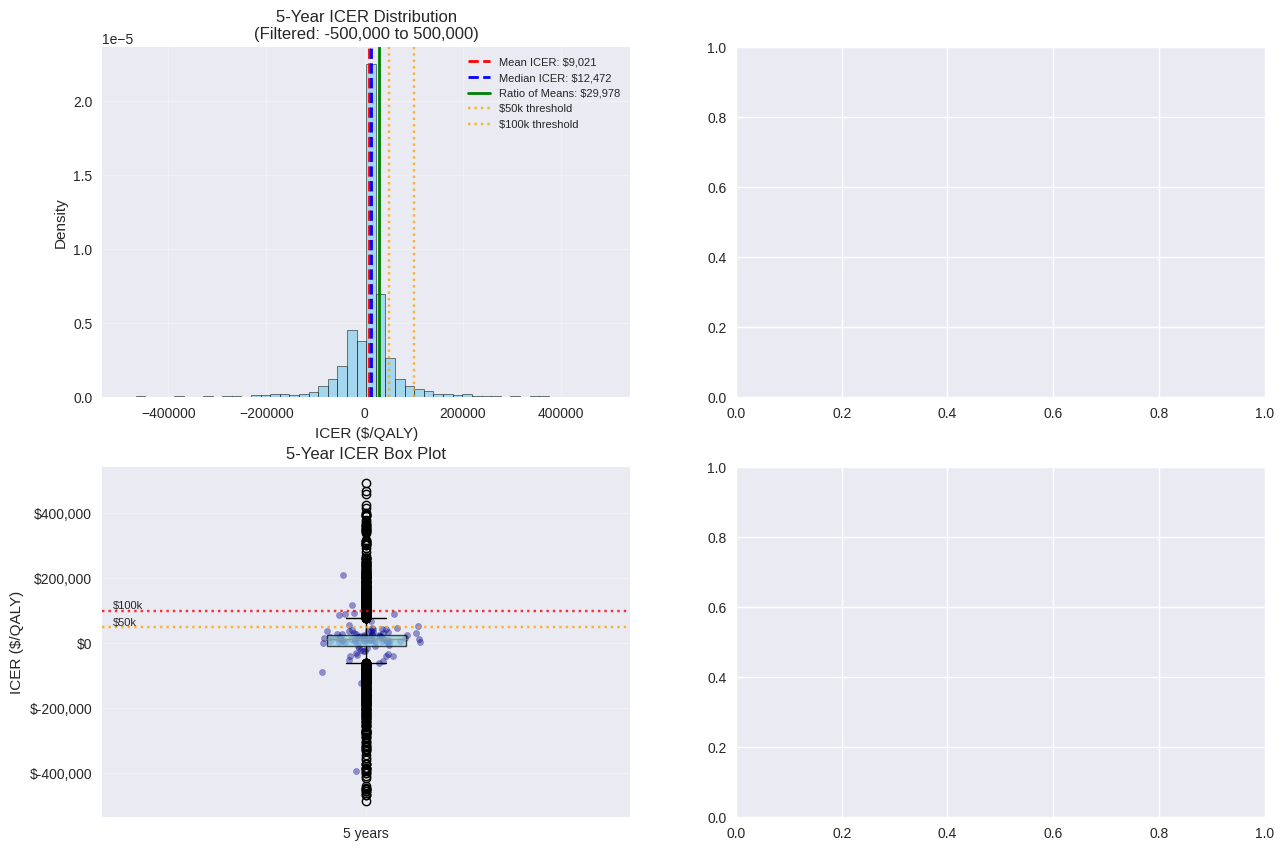

In [179]:
fig0, icer_data0 = plot_icer_distributions(ai_eff0_psa_results, non_ai_psa_results)


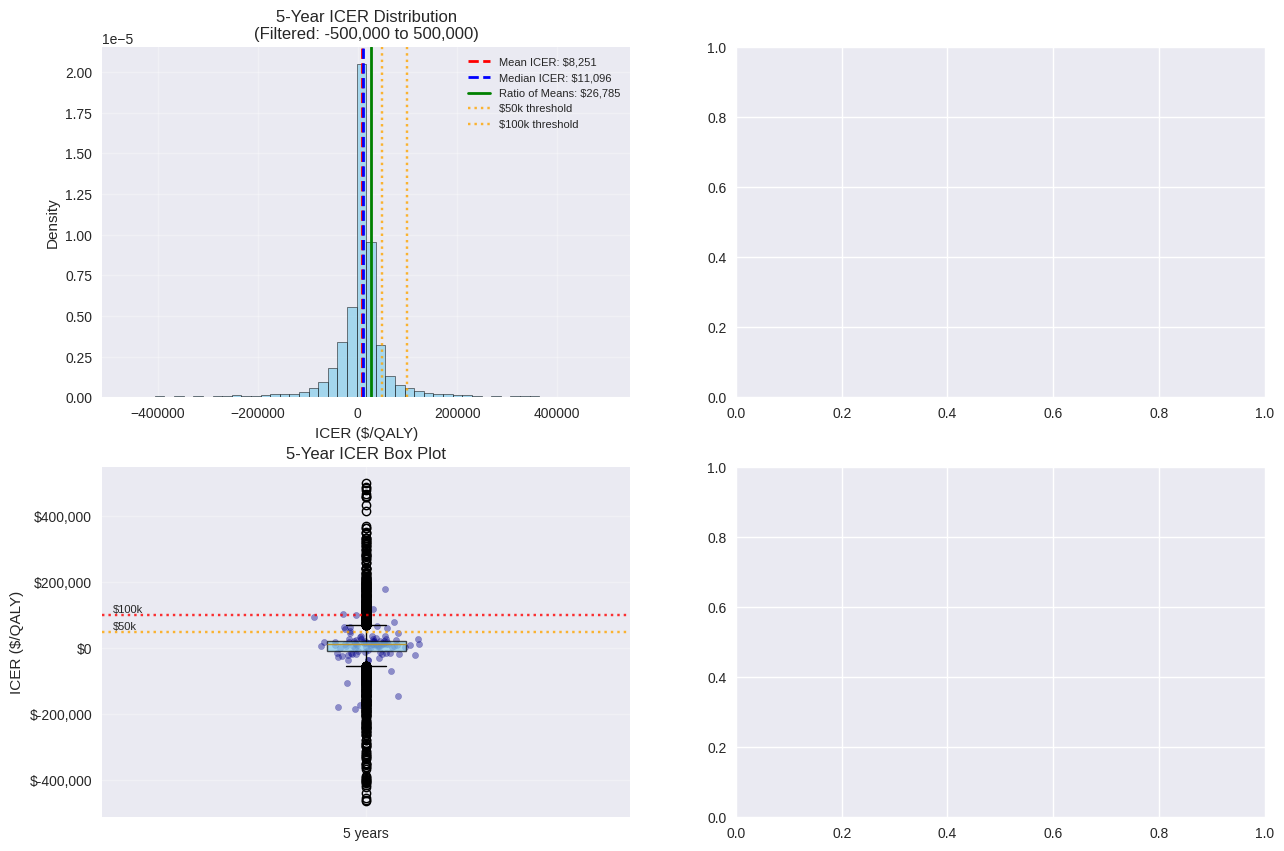

In [172]:
fig1, icer_data1 = plot_icer_distributions(ai_eff1_psa_results, non_ai_psa_results)

In [155]:
def plot_cost_effectiveness_acceptability_curve(icer_data, figsize=(12, 6)):
    """
    Plot cost-effectiveness acceptability curves using filtered ICER data

    Parameters:
    - icer_data: Dictionary from plot_icer_distributions
    - figsize: Figure size

    Returns:
    - matplotlib figure
    """

    thresholds = np.arange(0, 200001, 5000)  # $0 to $200k in $5k increments

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    colors = ['blue', 'red', 'green', 'orange']

    for i, (horizon, data) in enumerate(icer_data.items()):
        incremental_costs = data['incremental_costs']
        incremental_qalys = data['incremental_qalys']
        color = colors[i % len(colors)]

        # Calculate probabilities for each threshold
        prob_strict = []
        prob_relaxed = []

        for threshold in thresholds:
            # Strict definition: dominates OR (costs more but ICER <= threshold)
            dominates = (incremental_costs < 0) & (incremental_qalys > 0)
            cost_effective_positive = (incremental_costs > 0) & (incremental_qalys > 0) & \
                                     ((incremental_costs / incremental_qalys) <= threshold)
            strict_ce = dominates | cost_effective_positive
            prob_strict.append(np.sum(strict_ce) / len(strict_ce) * 100)

            # Relaxed definition: saves money OR (costs more but ICER <= threshold)
            saves_money = incremental_costs < 0
            relaxed_ce = saves_money | cost_effective_positive
            prob_relaxed.append(np.sum(relaxed_ce) / len(relaxed_ce) * 100)

        # Plot strict definition
        ax1.plot(thresholds, prob_strict, linewidth=2, color=color,
                label=f'{horizon} years', marker='o', markersize=3, alpha=0.8)

        # Plot relaxed definition
        ax2.plot(thresholds, prob_relaxed, linewidth=2, color=color,
                label=f'{horizon} years', marker='s', markersize=3, alpha=0.8)

    # Format strict plot
    ax1.set_xlabel('Willingness-to-Pay Threshold ($/QALY)')
    ax1.set_ylabel('Probability Cost-Effective (%)')
    ax1.set_title('Cost-Effectiveness Acceptability Curve\n(Strict: Requires QALY Gain)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    ax1.set_xlim(0, 200000)

    # Add reference lines
    for thresh, label in [(20000, '$20k'), (50000, '$50k'), (100000, '$100k')]:
        ax1.axvline(x=thresh, color='gray', linestyle='--', alpha=0.7)
        ax1.text(thresh, 95, label, rotation=90, verticalalignment='top',
                horizontalalignment='right', fontsize=9)

    # Format relaxed plot
    ax2.set_xlabel('Willingness-to-Pay Threshold ($/QALY)')
    ax2.set_ylabel('Probability Cost-Effective (%)')
    ax2.set_title('Cost-Effectiveness Acceptability Curve\n(Relaxed: Includes Cost Savings)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    ax2.set_xlim(0, 200000)

    # Add reference lines
    for thresh, label in [(20000, '$20k'), (50000, '$50k'), (100000, '$100k')]:
        ax2.axvline(x=thresh, color='gray', linestyle='--', alpha=0.7)
        ax2.text(thresh, 95, label, rotation=90, verticalalignment='top',
                horizontalalignment='right', fontsize=9)

    plt.tight_layout()
    return fig


def comprehensive_icer_analysis(ai_results, nonai_results, time_horizons=[5, 10],
                               icer_limits=(-500000, 500000), confidence_level=0.95):
    """
    Complete ICER analysis with distributions, statis0tics, and acceptability curves

    Parameters:
    - ai_results, nonai_results: Model results with traces
    - time_horizons: Time horizons to analyze
    - icer_limits: Outlier filtering limits
    - confidence_level: Confidence level for CIs

    Returns:
    - Dictionary with all analysis components
    """

    print(f"Running comprehensive ICER analysis for {time_horizons} year horizons...")

    # Generate ICER distributions and data
    fig_dist, icer_data = plot_icer_distributions(
        ai_results, nonai_results, time_horizons=time_horizons,
        icer_limits=icer_limits, discounted=True
    )

    # Create summary statistics table
    summary_stats = create_icer_summary_statistics(icer_data, confidence_level)

    # Generate cost-effectiveness plane
    fig_plane = plot_cost_effectiveness_plane(
        ai_results, nonai_results, time_horizons=time_horizons
    )

    # Generate acceptability curves
    fig_ceac = plot_cost_effectiveness_acceptability_curve(icer_data)

    print("\n=== ICER SUMMARY WITH 95% CI AND COST-EFFECTIVENESS PROBABILITIES ===")
    print(summary_stats[['Time_Horizon', 'Median_ICER', 'Ratio_of_Means', 'ICER_95CI',
                        'CE_20k', 'CE_50k', 'CE_100k']].to_string(index=False))

    return {
        'icer_data': icer_data,
        'summary_statistics': summary_stats,
        'distribution_plot': fig_dist,
        'cost_effectiveness_plane': fig_plane,
        'acceptability_curves': fig_ceac,
        'analysis_parameters': {
            'time_horizons': time_horizons,
            'icer_limits': icer_limits,
            'confidence_level': confidence_level,
            'discounted': True
        }
    }


# Enhanced example function
def example_complete_icer_analysis():
    """
    Example of running complete ICER analysis with all enhancements
    """

    print("=== COMPLETE ICER ANALYSIS WITH 95% CI AND CE PROBABILITIES ===")

    # Assuming you have ai_results and nonai_results with traces
    # Run comprehensive analysis
    analysis_results = comprehensive_icer_analysis(
        ai_results, non_ai_results,
        time_horizons=[5, 10],
        icer_limits=(-200000, 300000),  # Adjust based on your data
        confidence_level=0.95
    )

    # Display key results
    print("\n=== KEY FINDINGS ===")
    summary = analysis_results['summary_statistics']

    for _, row in summary.iterrows():
        horizon = row['Time_Horizon']
        median_icer = row['Median_ICER']
        ratio_means = row['Ratio_of_Means']
        ci = row['ICER_95CI']
        ce_20k = row['CE_20k']
        ce_50k = row['CE_50k']
        ce_100k = row['CE_100k']

        print(f"\n{horizon}:")
        print(f"  Median ICER: {median_icer}")
        print(f"  Ratio of Means: {ratio_means}")
        print(f"  95% CI: {ci}")
        print(f"  Probability CE at $20k/QALY: {ce_20k}")
        print(f"  Probability CE at $50k/QALY: {ce_50k}")
        print(f"  Probability CE at $100k/QALY: {ce_100k}")

    return analysis_results

print("Enhanced ICER analysis functions defined!")
print("\nNew features added:")
print("- 95% confidence intervals on filtered ICERs")
print("- Cost-effectiveness probabilities at $20k, $50k, $100k thresholds")
print("- Cost-effectiveness acceptability curves")
print("- Comprehensive analysis function")
print("\nUsage:")
print("1. fig, data = plot_icer_distributions(ai_results, nonai_results)")
print("2. summary = create_icer_summary_statistics(data)")
print("3. analysis = comprehensive_icer_analysis(ai_results, nonai_results)")


def create_icer_summary_statistics(icer_data, confidence_level=0.95):
    """
    Create a summary table of ICER statistics with confidence intervals and cost-effectiveness probabilities

    Parameters:
    - icer_data: Dictionary from plot_icer_distributions
    - confidence_level: Confidence level for intervals (default 0.95)

    Returns:
    - pandas DataFrame with summary statistics including CIs and CE probabilities
    """

    summary_rows = []
    thresholds = [20000, 50000, 100000]  # Cost-effectiveness thresholds

    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100

    for horizon, data in icer_data.items():
        icers_filtered = data['icers_filtered']
        incremental_costs = data['incremental_costs']
        incremental_qalys = data['incremental_qalys']

        if len(icers_filtered) > 0:
            # Calculate 95% CI on filtered ICERs
            icer_ci_lower = np.percentile(icers_filtered, lower_percentile)
            icer_ci_upper = np.percentile(icers_filtered, upper_percentile)

            # Calculate cost-effectiveness probabilities
            ce_probs = {}
            for threshold in thresholds:
                # Cost-effective if:
                # 1. Dominates: lower cost AND higher QALYs
                # 2. ICER below threshold: higher cost AND higher QALYs AND ICER <= threshold
                # 3. Saves money: lower cost (relaxed definition)

                dominates = (incremental_costs < 0) & (incremental_qalys > 0)
                saves_money = incremental_costs < 0
                cost_effective_positive = (incremental_costs > 0) & (incremental_qalys > 0) & \
                                         ((incremental_costs / incremental_qalys) <= threshold)

                # Use relaxed definition (includes cost savings)
                cost_effective = saves_money | cost_effective_positive
                ce_prob = np.sum(cost_effective) / len(cost_effective) * 100
                ce_probs[f'CE_{threshold//1000}k'] = f"{ce_prob:.1f}%"

            stats_dict = {
                'Time_Horizon': f'{horizon} years',
                'N_Simulations': len(data['icers_all']),
                'N_Finite': len(data['icers_finite']),
                'N_Filtered': len(icers_filtered),
                'Mean_ICER': f'${np.mean(icers_filtered):,.0f}',
                'Median_ICER': f'${np.median(icers_filtered):,.0f}',
                'Ratio_of_Means': f'${data["ratio_of_means"]:,.0f}' if np.isfinite(data["ratio_of_means"]) else 'N/A',
                'ICER_95CI': f'[${icer_ci_lower:,.0f}, ${icer_ci_upper:,.0f}]',
                'Std_ICER': f'${np.std(icers_filtered):,.0f}',
                'IQR_ICER': f'${np.percentile(icers_filtered, 75) - np.percentile(icers_filtered, 25):,.0f}',
                'P25_ICER': f'${np.percentile(icers_filtered, 25):,.0f}',
                'P75_ICER': f'${np.percentile(icers_filtered, 75):,.0f}',
                'Min_ICER': f'${np.min(icers_filtered):,.0f}',
                'Max_ICER': f'${np.max(icers_filtered):,.0f}',
            }
            # Add cost-effectiveness probabilities
            stats_dict.update(ce_probs)

        else:
            stats_dict = {
                'Time_Horizon': f'{horizon} years',
                'N_Simulations': len(data['icers_all']),
                'N_Finite': len(data['icers_finite']),
                'N_Filtered': 0,
                'Mean_ICER': 'N/A',
                'Median_ICER': 'N/A',
                'Ratio_of_Means': 'N/A',
                'ICER_95CI': 'N/A',
                'Std_ICER': 'N/A',
                'IQR_ICER': 'N/A',
                'P25_ICER': 'N/A',
                'P75_ICER': 'N/A',
                'Min_ICER': 'N/A',
                'Max_ICER': 'N/A',
                'CE_20k': 'N/A',
                'CE_50k': 'N/A',
                'CE_100k': 'N/A',
            }

        summary_rows.append(stats_dict)

    return pd.DataFrame(summary_rows)


def plot_cost_effectiveness_plane(ai_results, nonai_results, time_horizons=[5, 10],
                                 discounted=True, figsize=(12, 5)):
    """
    Plot cost-effectiveness planes for multiple time horizons

    Parameters:
    - ai_results, nonai_results: Model results with traces
    - time_horizons: Time horizons to plot
    - discounted: Use discounted values
    - figsize: Figure size

    Returns:
    - matplotlib figure
    """

    n_horizons = len(time_horizons)
    fig, axes = plt.subplots(1, n_horizons, figsize=figsize)
    if n_horizons == 1:
        axes = [axes]

    colors = ['blue', 'red', 'green', 'orange']

    for i, horizon in enumerate(time_horizons):
        ax = axes[i]

        # Calculate incremental values for this time horizon
        icer_results = calculate_icer_with_time_horizon(
            ai_results, nonai_results, time_horizon=horizon, discounted=discounted
        )

        incremental_costs = icer_results['incremental_costs']
        incremental_qalys = icer_results['incremental_qalys']

        # Scatter plot
        ax.scatter(incremental_qalys, incremental_costs, alpha=0.6, s=20,
                  color=colors[i % len(colors)])

        # Add threshold lines
        qaly_range = ax.get_xlim()
        cost_range = ax.get_ylim()

        # WTP threshold lines
        for threshold, color, label in [(50000, 'red', '$50k/QALY'), (100000, 'orange', '$100k/QALY')]:
            if qaly_range[1] > 0:
                max_qaly = min(qaly_range[1], cost_range[1]/threshold if threshold > 0 else qaly_range[1])
                threshold_x = np.linspace(0, max_qaly, 100)
                threshold_y = threshold_x * threshold
                ax.plot(threshold_x, threshold_y, '--', color=color, alpha=0.8,
                       linewidth=2, label=label)

        # Add quadrant lines
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)

        # Labels and formatting
        ax.set_xlabel('Incremental QALYs (AI - Non-AI)')
        ax.set_ylabel('Incremental Costs ($)')
        ax.set_title(f'Cost-Effectiveness Plane\n({horizon} years)')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add quadrant labels
        ax.text(0.95, 0.95, 'More Effective\nMore Costly', transform=ax.transAxes,
               ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax.text(0.05, 0.05, 'Less Effective\nMore Costly', transform=ax.transAxes,
               ha='left', va='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        ax.text(0.95, 0.05, 'Less Effective\nLess Costly', transform=ax.transAxes,
               ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
        ax.text(0.05, 0.95, 'More Effective\nLess Costly\n(Dominates)', transform=ax.transAxes,
               ha='left', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    return fig


def example_icer_distribution_analysis():
    """
    Example of ICER distribution analysis
    """

    print("Running ICER distribution analysis...")

    # Run models with traces
    ai_model = AIGlaucomaModel()
    nonai_model = NonAIGlaucomaModel()

    ai_results = ai_model.run_probabilistic(n_iterations=1000, years=15, return_traces=True)
    nonai_results = nonai_model.run_probabilistic(n_iterations=1000, years=15, return_traces=True)

    # Plot ICER distributions
    fig1, icer_data = plot_icer_distributions(
        ai_results, non_ai_results,
        time_horizons=[5, 10],
        icer_limits=(-200000, 300000)
    )

    # Create summary statistics
    summary_stats = create_icer_summary_statistics(icer_data)
    print("\n=== ICER DISTRIBUTION SUMMARY ===")
    print(summary_stats.to_string(index=False))

    # Plot cost-effectiveness planes
    fig2 = plot_cost_effectiveness_plane(ai_results, non_ai_results, time_horizons=[5, 10])

    return fig1, fig2, icer_data, summary_stats

print("ICER distribution plotting functions defined!")
print("\nUsage:")
print("1. fig, data = plot_icer_distributions(ai_results, nonai_results, time_horizons=[5, 10])")
print("2. summary = create_icer_summary_statistics(data)")
print("3. plane_fig = plot_cost_effectiveness_plane(ai_results, nonai_results)")
print("4. figs, data, summary = example_icer_distribution_analysis()")

Enhanced ICER analysis functions defined!

New features added:
- 95% confidence intervals on filtered ICERs
- Cost-effectiveness probabilities at $20k, $50k, $100k thresholds
- Cost-effectiveness acceptability curves
- Comprehensive analysis function

Usage:
1. fig, data = plot_icer_distributions(ai_results, nonai_results)
2. summary = create_icer_summary_statistics(data)
3. analysis = comprehensive_icer_analysis(ai_results, nonai_results)
ICER distribution plotting functions defined!

Usage:
1. fig, data = plot_icer_distributions(ai_results, nonai_results, time_horizons=[5, 10])
2. summary = create_icer_summary_statistics(data)
3. plane_fig = plot_cost_effectiveness_plane(ai_results, nonai_results)
4. figs, data, summary = example_icer_distribution_analysis()


In [158]:
summary = create_icer_summary_statistics(icer_data0)
print("\n=== ICER DISTRIBUTION SUMMARY scenario 0===")
print(summary.to_string(index=False))


=== ICER DISTRIBUTION SUMMARY ===
Time_Horizon  N_Simulations  N_Finite  N_Filtered Mean_ICER Median_ICER Ratio_of_Means             ICER_95CI Std_ICER IQR_ICER P25_ICER P75_ICER  Min_ICER Max_ICER CE_20k CE_50k CE_100k
     5 years           5000      5000        4883    $9,021     $12,472        $29,978 [$-154,648, $159,041]  $72,187  $34,554  $-9,145  $25,409 $-485,887 $492,801  39.4%  60.3%   66.4%
    10 years           5000      5000        4953    $1,743      $2,389         $5,238   [$-71,442, $67,382]  $42,902  $11,528  $-3,571   $7,958 $-481,466 $428,432  73.6%  79.5%   81.2%


In [173]:
summary = create_icer_summary_statistics(icer_data1)
print("\n=== ICER DISTRIBUTION SUMMARY scenario 1===")
print(summary.to_string(index=False))


=== ICER DISTRIBUTION SUMMARY scenario 1===
Time_Horizon  N_Simulations  N_Finite  N_Filtered Mean_ICER Median_ICER Ratio_of_Means             ICER_95CI Std_ICER IQR_ICER P25_ICER P75_ICER  Min_ICER Max_ICER CE_20k CE_50k CE_100k
     5 years           5000      5000        4895    $8,251     $11,096        $26,785 [$-142,873, $146,870]  $68,170  $30,755  $-8,045  $22,710 $-464,036 $498,928  43.2%  61.6%   67.1%
    10 years           5000      5000        4956      $958      $1,907         $4,240   [$-68,345, $60,255]  $41,839  $11,196  $-3,829   $7,367 $-493,082 $399,261  75.3%  80.7%   82.1%


In [138]:
# Test calculate_icer_with_time_horizon directly
try:
    test_result = calculate_icer_with_time_horizon(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizon=5, discounted=True
    )
    print("ICER calculation succeeded")
    print("Keys:", test_result.keys())
except Exception as e:
    print("ICER calculation failed:", str(e))

ICER calculation succeeded
Keys: dict_keys(['time_horizon', 'years_included', 'n_simulations', 'discounted', 'incremental_costs', 'incremental_costs_mean', 'incremental_costs_std', 'incremental_costs_median', 'incremental_qalys', 'incremental_qalys_mean', 'incremental_qalys_std', 'incremental_qalys_median', 'icers', 'finite_icers', 'icer_mean', 'icer_median', 'ai_mean_cost', 'ai_mean_qalys', 'nonai_mean_cost', 'nonai_mean_qalys'])


In [135]:
def example_icer_distribution_analysis():
    """
    Example of ICER distribution analysis
    """

    print("Running ICER distribution analysis...")

    # Run models with traces
    #ai_model = AIGlaucomaModel()
    #nonai_model = NonAIGlaucomaModel()

    #ai_results = ai_model.run_probabilistic(n_iterations=1000, years=15, return_traces=True)
    #nonai_results = nonai_model.run_probabilistic(n_iterations=1000, years=15, return_traces=True)

    # Plot ICER distributions
    fig1, icer_data = plot_icer_distributions(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10],
        icer_limits=(-200000, 300000)
    )

    # Create summary statistics
    summary_stats = create_icer_summary_statistics(icer_data)
    print("\n=== ICER DISTRIBUTION SUMMARY ===")
    print(summary_stats.to_string(index=False))

    # Plot cost-effectiveness planes
    fig2 = plot_cost_effectiveness_plane(ai_psa_results, non_ai_psa_results, time_horizons=[5, 10])

    return fig1, fig2, icer_data, summary_stats

print("ICER distribution plotting functions defined!")
print("\nUsage:")
print("1. fig, data = plot_icer_distributions(ai_results, nonai_results, time_horizons=[5, 10])")
print("2. summary = create_icer_summary_statistics(data)")
print("3. plane_fig = plot_cost_effectiveness_plane(ai_results, nonai_results)")
print("4. figs, data, summary = example_icer_distribution_analysis()")

ICER distribution plotting functions defined!

Usage:
1. fig, data = plot_icer_distributions(ai_results, nonai_results, time_horizons=[5, 10])
2. summary = create_icer_summary_statistics(data)
3. plane_fig = plot_cost_effectiveness_plane(ai_results, nonai_results)
4. figs, data, summary = example_icer_distribution_analysis()


Running ICER distribution analysis...


TypeError: cannot unpack non-iterable NoneType object

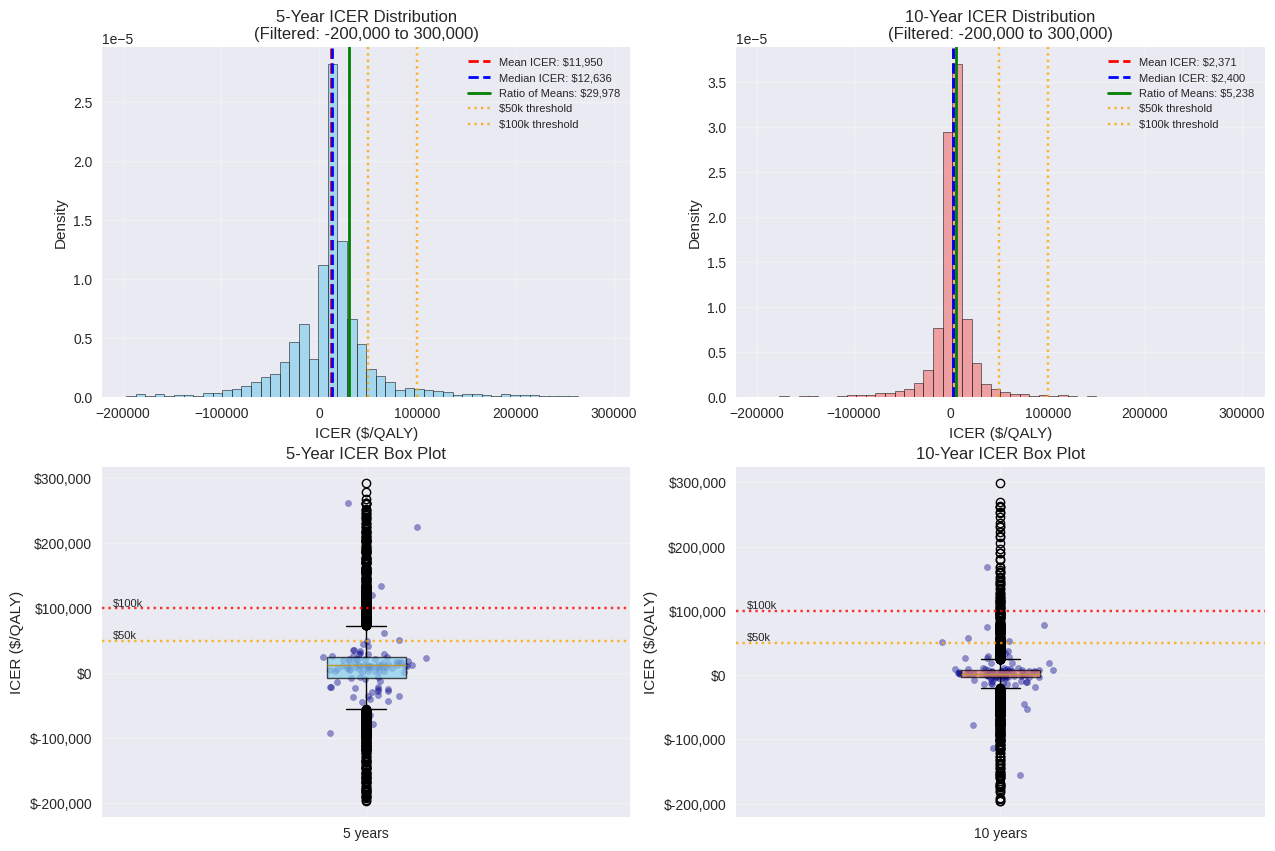

In [136]:
example_icer_distribution_analysis()